In [28]:
import pandas as pd

# Adjust display settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)
pd.set_option('display.precision', 2)


In [37]:
import pandas as pd
import numpy as np
from plotly import express as px
import matplotlib.pyplot as plt

import os
import sys
import json
import datetime
from typing import List, Callable, Tuple


from dotenv import load_dotenv 
load_dotenv()

## handles json format: [[obfuscator_name, [prompt_dict, prompt_dict, ...]], [obfuscator_name, [prompt_dict, prompt_dict, ...]], ...]

class PlotClass:
    """
    Args:
        inputfile_path (`str`): path to the json file containing the data
        metrics (`list`): list of metrics to be plotted
    """
    def _handle_dict_metric(self, data, metrics):
        for metric in metrics:
            need_handling = False
            if isinstance(data[0][1][0][metric],dict):
                    need_handling = True
                    break 
        if not need_handling:
            return data
        for metric in metrics:
            for obf_index, obfuscator in enumerate(data):
                for test_index, test in enumerate(obfuscator[1]):
                    if isinstance(test[metric],dict):
                        for key in test[metric].keys():
                            data[obf_index][1][test_index][metric + "_"+ key] = data[obf_index][1][test_index][metric][key]
                        data[obf_index][1][test_index].pop(metric)
        return data
    
    def __init__ (self, inputfile_path, metrics):
        with open(inputfile_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
        data = self._handle_dict_metric(data,metrics)
        
        df_list = []
        for obfuscator in data:
            df_structure = pd.DataFrame(obfuscator[1])
            df_structure['ObfuscatorName'] = obfuscator[0]
            df_structure['question_index'] = df_structure.index 

            df_list.append(df_structure)

        self._df = pd.concat(df_list, ignore_index=True)
    
    def generate_statistic_figure(self,prompt_metrics: List[str],answer_metrics: List[str], list_messurements: List[Tuple[str,Callable[[pd.Series], float]]]):
        agg_dict = {}
        for prompt_metric,answer_metric in zip(prompt_metrics,answer_metrics):
            for messurement_name, messurement_function in list_messurements:
                agg_dict[f"{messurement_name} {prompt_metric}"] = (prompt_metric, messurement_function)
                agg_dict[f"{messurement_name} {answer_metric}"] = (answer_metric, messurement_function)

                
        value_vars = list(agg_dict.keys())
        stats_df = self._df.groupby(['ObfuscatorName']).agg(**agg_dict).reset_index()

        # Melt the DataFrame to have a long-form DataFrame suitable for Plotly
        melted_df = stats_df.melt(id_vars=['ObfuscatorName'], 
                              value_vars=value_vars,
                              var_name='statistic', value_name='value')

        fig = px.bar(melted_df, x='statistic', y='value', 
                facet_col='ObfuscatorName', barmode='group',
                color = 'statistic'
                )
    
        fig.update_layout(
        title='Metrics by Obfuscator and Metric Type',
        xaxis_title='ObfuscatorName',
        yaxis_title='Value',
        bargap=0.1,
        bargroupgap=0.00001
            )
        fig.update_traces(width=0.5)

        # Rename the title of each subplot
        for annotation in fig.layout.annotations:
            if 'ObfuscatorName=' in annotation.text:
                obfuscator_name = annotation.text.split('=')[1]
                annotation.text = f'{obfuscator_name}'
    
        return fig
    

    def show_statistic_graph(self,prompt_metric: List[str],answer_metric: List[str], list_messurements: List[Tuple[str,Callable[[pd.Series], float]]]):
        self.generate_statistic_figure(prompt_metric,answer_metric, list_messurements).show()
    def save_statistic_graph(self,prompt_metric,answer_metric,save_path):
        self.generate_statistic_figure(prompt_metric,answer_metric).write_html(save_path + "_statistic_graph.html")

    def generate_individual_figure(self,prompt_metric,answer_metric,sample_size):
        np.random.seed(0)
        data_size = (self._df['ObfuscatorName'] == self._df['ObfuscatorName'].unique().tolist()[0]).sum()
        sample = np.random.choice(data_size, size=sample_size, replace=False)


        df = self._df[self._df['question_index'].isin(sample)]
        df_prompt = df[['ObfuscatorName'] + prompt_metric + ['obfuscated_prompt', 'question_index']].copy()
        df_answer = df[['ObfuscatorName'] + answer_metric + ['deobfuscated_answer', 'question_index']].copy() 
    
        melted_df_prompt = df_prompt.melt(id_vars=['ObfuscatorName', 'obfuscated_prompt', 'question_index'], 
                                            value_vars=prompt_metric,
                                            var_name='metric_type', value_name='value')
        melted_df_answer = df_answer.melt(id_vars=['ObfuscatorName', 'deobfuscated_answer', 'question_index'], 
                                        value_vars=answer_metric,
                                        var_name='metric_type', value_name='value')
        melted_df_answer.rename(columns={'deobfuscated_answer': 'llm_text'}, inplace=True)
        melted_df_prompt.rename(columns={'obfuscated_prompt': 'llm_text'}, inplace=True)

        df_final = pd.concat([melted_df_prompt, melted_df_answer], ignore_index=True)

        fig = px.bar(df_final, x='metric_type', y='value', 
                    facet_col='question_index', barmode='group',
                    color = 'ObfuscatorName', hover_data={'llm_text': True, 'metric_type': False, 'value': False, 'question_index': False, 'ObfuscatorName': False}
                    )
        
        fig.update_layout(
            title='Individual answers',
            xaxis_title='ObfuscatorName',
            yaxis_title='Value'
        )

        
        return fig 
     
    def show_individual_graph(self,prompt_metric,answer_metric, sample_size):
        self.generate_individual_figure(prompt_metric,answer_metric, sample_size).show()
    def save_individual_graph(self,prompt_metric,answer_metric, sample_size, save_path):
        self.generate_individual_figure(prompt_metric,answer_metric, sample_size).write_html(save_path + "_individual_graph.html")

    def save_statistic_scatter_graph(self, metricA: str, metricB: str, save_path: str):
        correlation = self._df[metricA].corr(self._df[metricB])
        px.scatter(self._df, x=metricA, y=metricB, color='ObfuscatorName',
            title=f"Correlation between {metricA} and {metricB}: {correlation}"
            ).write_html(save_path + "scatter_graph.html")

    
    def show_statistic_scatter_graph(self, metricA: str, metricB: str):
        print(self._df['ObfuscatorName'].unique().tolist())
        print(self._df.groupby(by= 'ObfuscatorName',group_keys=True))
        correlation_df = self._df.groupby('ObfuscatorName',group_keys=True).apply(
        lambda group: group[metricA].corr(group[metricB])
        ).reset_index(drop=True)
        obfuscators_list = self._df['ObfuscatorName'].unique().tolist()
        correlation_dict = dict(zip(obfuscators_list,correlation_df))


        for index, row in self._df.iterrows():
            self._df.at[index, f'{metricA} to {metricB}'] = correlation_dict[row['ObfuscatorName']]

        print(self._df[f'{metricA} to {metricB}'])        
        fig = px.scatter(self._df, x=metricA, y=metricB, range_x=[0,1],range_y=[0,1],color='ObfuscatorName' , hover_data={f'{metricA} to {metricB}': True})

        # Show the plot
        fig.show()

        # correlation = self._df[metricA].corr(self._df[metricB])
        # px.scatter(
        #     self._df, x=metricA, y=metricB, color='ObfuscatorName',
        #     title=f"Correlation between {metricA} and {metricB}: {correlation}"
        #     #size='prompt_metric_llm_similarity'
        #     ).show()

if __name__ == "__main__":
    file_name = "filltered_data_result.json"
    
    inputfile_path = os.path.join(os.getenv("PROJECT_PATH"),"data","15-08-2024", file_name)
    metrics = ["prompt_metric","answer_metric"]
    
    graph = PlotClass(inputfile_path, metrics)


    outputfile_folder = os.path.join(os.getenv("PROJECT_PATH"),"data","18-08-2024")
    os.makedirs(outputfile_folder, exist_ok=True)
    outputfile_path = os.path.join(outputfile_folder, file_name.strip(".json"))

    list_messurements = [
        ("average", 'mean'),
        ("top decile", lambda x: x.quantile(0.9)),
        ("bottom decile", lambda x: x.quantile(0.1))
    ]

    print(graph._df.loc[0])
    graph.show_statistic_scatter_graph("answer_metric_llm_similarity", "answer_metric_ada_similarity")



original_answer                 Integrating AI-powered decision support modules into Cerner's existing EHR system while ensuring compliance with HIPAA and maintaining data security involves several key considerations:\n\n1. **Data Privacy and Security**:\n   - **Encryption**: Ensure that all patient data, both in transit and at rest, is encrypted using robust encryption standards.\n   - **Access Controls**: Implement strict access controls to ensure that only authorized personnel can access sensitive patient data. This includes role-based access and multi-factor authentication.\n   - **Audit Trails**: Maintain detailed audit logs to track access and modifications to patient data, which can help in identifying and responding to unauthorized access or data breaches.\n\n2. **Regulatory Compliance**:\n   - **HIPAA Compliance**: Ensure that all aspects of the AI integration comply with HIPAA regulations, which include safeguarding patient information, ensuring data integrity, and providing 

In [12]:
import os
import json
from dotenv import load_dotenv 
load_dotenv()

path = os.path.join(os.getenv("PROJECT_PATH"),"data","18-08-2024","RESULTS_context_test_2024-08-19_00_40_56.378972.json")

with open(path, 'r', encoding='utf-8') as file:
    data = json.load(file)


answer_results =[]
for obfuscator in data:
    obfuscator_name = obfuscator[0]
    if obfuscator_name != "ContextOnlyObfuscator":
        continue
    for dict_case in obfuscator[1]:
        answer_results.append(dict_case['answer_metric']['llm_similarity'])
        # if dict_case['answer_metric']['llm_similarity'] == "🤔":
        #     print(obfuscator_name)
        #     break

answer_results.sort()
answer_results.count
print([(a,answer_results.count(a)) for a in set(answer_results)])

[(0.3, 2), (0.4, 1), (0.6, 2), (0.75, 7), (0.7, 8), (0.85, 30)]


In [17]:
from colorama import Fore, Back, Style

for obfuscator in data:
    obfuscator_name = obfuscator[0]
    if obfuscator_name != "ContextOnlyObfuscator":
        continue
    for dict_case in obfuscator[1]:
        if dict_case['answer_metric']['llm_similarity'] <= 0.4:
            i = 0
            for key, value in dict_case.items():
                print(Fore.YELLOW + f"{key}: {value}") if i%2==0 else print(Fore.CYAN + f"{key}: {value}")
                i +=1

            print("__________________________________")


original_answer: Ensuring data privacy and compliance with global regulations like GDPR when integrating AI tools into existing cloud platforms such as Microsoft Azure involves a multi-faceted approach. Here are some best practices:

1. **Data Minimization and Anonymization**:
   - **Data Minimization**: Collect only the data that is necessary for the AI tools to function. Avoid gathering excessive or irrelevant information.
   - **Anonymization and Pseudonymization**: Use techniques to anonymize or pseudonymize data to protect individual identities. This reduces the risk of data breaches and helps in compliance with GDPR.

2. **Encryption and Secure Data Storage**:
   - **Encryption**: Encrypt data both in transit and at rest to protect it from unauthorized access. Use strong encryption standards and regularly update encryption protocols.
   - **Secure Storage**: Store data in secure, compliant data centers. Ensure that the cloud platform provides robust security measures, such as Azu

In [24]:
from src.utils.azure_client import get_answer

answer_prompt = """give a number between 0.0 to 1.0 where 0.0 is not similar at all and 1.0 signifies that the texts are highly similar, discussing the same topic, sharing the same opinion, and covering the same key details. The two following texts:
Text1: {text1}
Text2: {text2}
Please provide the similarity score along with a brief explanation of the rationale behind the score. Print $ANSWER: <number>"""

text1 ="""
When implementing advanced analytics and machine learning solutions like UPS's ORION for optimizing delivery routes, ensuring compatibility with legacy systems and robust data privacy measures involves several key considerations:\n\n### Compatibility with Legacy Systems\n\n1. **Integration Strategy**:\n   - **API Development**: Develop APIs that can interface with legacy systems to facilitate data exchange without requiring significant changes to the existing infrastructure.\n   - **Middleware Solutions**: Use middleware to bridge the gap between new and old systems, ensuring seamless communication and data flow.\n\n2. **Data Consistency and Integrity**:\n   - **Data Mapping**: Ensure that data formats and structures are compatible between legacy systems and new solutions. This may involve data transformation and mapping processes.\n   - **Data Synchronization**: Implement mechanisms to keep data synchronized across systems to maintain consistency and accuracy.\n\n3. **Incremental Implementation**:\n   - **Phased Rollout**: Gradually implement the new system in phases to minimize disruption and allow for testing and adjustments.\n   - **Pilot Programs**: Start with pilot programs to test the integration on a smaller scale before full deployment.\n\n4. **Legacy System Support**:\n   - **Vendor Collaboration**: Work closely with vendors of legacy systems to understand their capabilities and limitations.\n   - **Documentation and Training**: Ensure thorough documentation and training for IT staff to manage and troubleshoot integration issues.\n\n5. **Performance Monitoring**:\n   - **Real-Time Monitoring**: Implement real-time monitoring tools to track the performance of integrated systems and quickly address any issues.\n   - **Scalability**: Ensure that the new system can scale without degrading the performance of legacy systems.\n\n### Robust Data Privacy Measures\n\n1. **Data Encryption**:\n   - **In-Transit and At-Rest**: Encrypt data both in transit and at rest to protect it from unauthorized access.\n   - **Advanced Encryption Standards**: Use industry-standard encryption protocols such as AES-256.\n\n2. **Access Control**:\n   - **Role-Based Access Control (RBAC)**: Implement RBAC to ensure that only authorized personnel have access to sensitive data.\n   - **Multi-Factor Authentication (MFA)**: Use MFA to add an extra layer of security for accessing critical systems and data.\n\n3. **Data Anonymization and Masking**:\n   - **Anonymization**: Remove personally identifiable information (PII) from datasets used for analytics to protect customer privacy.\n   - **Masking**: Mask sensitive data in non
"""

text2 = """
Key considerations include:
1. Ensuring seamless integration with existing 🖥️📜.
2. Implementing robust 🔒📄 protocols.
3. Maintaining data integrity and security.
4. Ensuring scalability and flexibility of the new system.
5. Providing comprehensive training for users.
6. Regularly updating and patching the system.
7. Conducting thorough testing and validation.
8. Ensuring compliance with relevant regulations and standards.
"""

for i in range (5):
   print(get_answer(answer_prompt.format(text1 =text1, text2 = text2)))
print("______________________switched____________________________")
for i in range (5):
   print(get_answer(answer_prompt.format(text1 =text2, text2 = text1)))

$ANSWER: 0.3

### Rationale:
The two texts discuss related topics but differ significantly in detail, structure, and focus. Here are the key points of comparison:

1. **Topic Similarity**:
   - Both texts address considerations for implementing new systems and ensuring data security.
   - Text1 is specifically about integrating advanced analytics and machine learning solutions with legacy systems, while Text2 is more general about key considerations for system implementation.

2. **Detail and Specificity**:
   - Text1 provides a detailed breakdown of strategies for compatibility with legacy systems and robust data privacy measures, including specific techniques like API development, middleware solutions, data encryption, and access control.
   - Text2 lists general considerations without going into specific methods or strategies.

3. **Structure and Format**:
   - Text1 is structured with headings and subheadings, providing a clear, organized approach to the topic.
   - Text2 is a simp

In [28]:
path = os.path.join(os.getenv("PROJECT_PATH"),"data","19-08-2024","RESULTS_smart_random_test_2024-08-19_13_26_46.259087.json")
with open(path, 'r', encoding='utf-8') as file:
    new_data = json.load(file)

In [95]:
def restirction(number: float) -> bool:
    return number <= 0.6
print("_________ContextReletiveObfuscator_____________")
for obfuscator in data:
    obfuscator_name = obfuscator[0]
    if obfuscator_name != "ContextReletiveObfuscator":
        continue
    for index, dict_case in enumerate(obfuscator[1]):
        if restirction(dict_case['answer_metric']['llm_similarity']):
            print(index, dict_case['answer_metric']['llm_similarity'] )


print("______________________")
for obfuscator in new_data:
    obfuscator_name = obfuscator[0]
    if obfuscator_name != "ContextReletiveObfuscator":
        continue
    for index, dict_case in enumerate(obfuscator[1]):
        if restirction(dict_case['answer_metric']['llm_similarity']):
            print(index, dict_case['answer_metric']['llm_similarity'] )

print("__________ContextOnlyObfuscator____________")
for obfuscator in data:
    obfuscator_name = obfuscator[0]
    if obfuscator_name != "ContextOnlyObfuscator":
        continue
    for index, dict_case in enumerate(obfuscator[1]):
        if restirction(dict_case['answer_metric']['llm_similarity']):
            print(index, dict_case['answer_metric']['llm_similarity'] )


print("______________________")
for obfuscator in new_data:
    obfuscator_name = obfuscator[0]
    if obfuscator_name != "ContextOnlyObfuscator":
        continue
    for index, dict_case in enumerate(obfuscator[1]):
        if restirction(dict_case['answer_metric']['llm_similarity']):
            print(index, dict_case['answer_metric']['llm_similarity'] )

_________ContextReletiveObfuscator_____________
15 0.6
48 0.6
______________________
15 0.3
17 0.4
28 0.3
30 0.3
__________ContextOnlyObfuscator____________
4 0.3
15 0.6
24 0.3
28 0.6
30 0.4
______________________
1 0.6
17 0.4


In [74]:
for obfuscator in new_data:
    obfuscator_name = obfuscator[0]
    if obfuscator_name != "ContextReletiveObfuscator":
        continue
    for index, dict_case in enumerate(obfuscator[1]):
        if index in [28] :
            old_data_dict = dict_case
            
for obfuscator in data:
    obfuscator_name = obfuscator[0]
    if obfuscator_name != "ContextReletiveObfuscator":
        continue
    for index, dict_case in enumerate(obfuscator[1]):
        if index in [28] :
            new_data_dict = dict_case

In [92]:
print(old_data_dict["answer_metric"])
print(old_data_dict["obfuscated_dictonary"])
print(new_data_dict["answer_metric"])
print(new_data_dict["obfuscated_dictonary"])

{'llm_similarity': 0.3, 'ada_similarity': 0.5954496577804179}
{'Microsoft': '🏢💻', 'hybrid work model': '🔄🏠💼', 'cloud-based productivity suite': '☁️📈📦', 'Microsoft 365': '🏢💻365', 'flexible work arrangements': '🤸\u200d♂️🏢🏠', 'high productivity levels': '📈💪', 'robust security': '🛡️🔒', 'Microsoft Teams': '🏢💻👥', 'virtual meetings': '🌐📞👥', 'collaboration': '🤝💻', 'OneDrive': '☁️📂', 'secure cloud storage': '🔐☁️📂', 'enhanced security features': '🛡️🔧', 'conditional access policies': '🔑🚪📜', 'data loss prevention strategies': '📉🛡️📋', 'seamless integration': '🔗✨', 'various devices': '📱💻🖥️', 'compliance': '✅📜', 'data protection regulations': '🛡️📜', 'GDPR': '🇪🇺📜', 'Jared Spataro': '👨\u200d💼📝', 'Corporate Vice President': '🏢👔', 'IT administrators': '💻🔧👨\u200d💼', 'cybersecurity experts': '🛡️💻👨\u200d💼', 'corporate compliance officers': '🏢✅👨\u200d💼'}
{'llm_similarity': 0.85, 'ada_similarity': 0.9062353961226584, 'MiniLM': 0.7433455586433411}
{'Microsoft': '🏢💻', 'hybrid work model': '🔄🏠💼', 'cloud-based pr

In [96]:
print(old_data_dict["deobfuscated_answer"])
print(new_data_dict["deobfuscated_answer"])

1. Implement multi-factor authentication (MFA) for all users.
2. Regularly update and patch all software and systems.
3. Use data encryption both in transit and at rest.
4. Conduct regular security awareness training for employees.
5. Monitor and audit access logs and user activities.
6. Ensure compliance with relevant regulations and standards.
7. Utilize advanced threat protection and endpoint security solutions.
8. Establish a robust incident response plan.
9. Perform regular security assessments and penetration testing.
10. Maintain clear and updated documentation of security policies and procedures.
To ensure robust security and compliance with data protection regulations while transitioning to a hybrid work model using Microsoft 365, consider the following best practices:

1. **Implement Multi-Factor Authentication (MFA)**: Enhance security by requiring multiple forms of verification.
2. **Regular Security Audits**: Conduct frequent audits to identify and mitigate vulnerabilities

In [93]:
from src.utils.string_utils import smart_replace, extract_number


answer_prompt = """give a number between 0.0 to 1.0 where 0.0 is not similar at all and 1.0 signifies that the texts are highly similar, discussing the same topic, sharing the same opinion, and covering the same key details. The two following texts:
Text1: {text1}
Text2: {text2}
Please provide the similarity score along with a brief explanation of the rationale behind the score. Print $ANSWER: <number>"""
    

def evaluate_answer(obfuscated_answer, original_answer):
        query = answer_prompt.format(text1=obfuscated_answer, text2=original_answer)        
        answer = get_answer(query)
        print(answer)
        llm_similarity = extract_number(answer)
        return llm_similarity

In [94]:
emoji_dict = {v:k for k,v in old_data_dict["obfuscated_dictonary"].items()}

for i in range(5):
    obfuscated_answer = get_answer(old_data_dict['obfuscated_prompt'])
    deobfuscated_answer = smart_replace(obfuscated_answer,emoji_dict)
    print(evaluate_answer(deobfuscated_answer, old_data_dict["original_answer"]))

$ANSWER: 0.6

The two texts share several common themes and recommendations related to cybersecurity best practices, such as implementing multi-factor authentication (MFA), ensuring data encryption, conducting regular security training, and performing regular security assessments. Both texts emphasize the importance of maintaining security and compliance, although Text2 is more focused on the context of using Microsoft 365 in a hybrid work model and includes specific tools and features related to Microsoft 365.

However, there are differences in the scope and details covered. Text1 provides a general list of cybersecurity measures applicable to any organization, while Text2 tailors its recommendations to the specific use case of Microsoft 365 and hybrid work environments, including conditional access policies, data loss prevention, and device management.

Overall, while the texts are similar in their overarching goals and some specific recommendations, they differ in context, focus, an

In [90]:
print(evaluate_answer(deobfuscated_answer, old_data_dict["original_answer"]))

$ANSWER: 0.6

The two texts share several common themes and recommendations related to cybersecurity best practices, such as implementing multi-factor authentication (MFA), ensuring data encryption, conducting regular security training, and performing security assessments. Both texts emphasize the importance of maintaining security and compliance, although Text2 is more focused on the context of using Microsoft 365 in a hybrid work model and includes specific strategies like conditional access policies, data loss prevention, and device management.

However, there are differences in the scope and details provided. Text1 presents a general list of cybersecurity measures applicable to any organization, while Text2 tailors its recommendations to the specific use of Microsoft 365 and includes additional context-specific strategies like secure cloud storage with OneDrive and using Microsoft Teams securely.

Overall, while the texts cover similar topics and share some key details, they are no

In [39]:
for obfuscator in data:
    obfuscator_name = obfuscator[0]
    if obfuscator_name != "ContextReletiveObfuscator":
        continue
    for index, dict_case in enumerate(obfuscator[1]):
        if index == 15:
            i = 0
            for key, value in dict_case.items():
                print(Fore.YELLOW + f"{key}: {value}") if i%2==0 else print(Fore.CYAN + f"{key}: {value}")
                i +=1

            print("__________________________________")

original_answer: Ensuring interoperability between legacy systems and new IoT-enabled devices is a critical aspect of implementing smart factory technologies, as demonstrated by BMW's Industry 4.0 initiative. Here are the key considerations for achieving this:

1. **Standardization of Communication Protocols**:
   - **Adopt Common Standards**: Utilize widely accepted industrial communication protocols such as OPC UA (Open Platform Communications Unified Architecture), MQTT (Message Queuing Telemetry Transport), and others to facilitate seamless data exchange.
   - **Middleware Solutions**: Implement middleware that can translate and mediate between different protocols used by legacy systems and new IoT devices.

2. **Data Integration and Management**:
   - **Unified Data Models**: Develop a unified data model that can accommodate data from both legacy systems and new IoT devices, ensuring consistency and compatibility.
   - **Data Mapping and Transformation**: Use data mapping tools to

In [47]:
prompt = """Do not explain the emojis in your answer and do not add new emojis that were not in the original question.
Context: In 2018, global automotive giant 🚗🌍 began implementing 📊🤖 and 🌐🔧 within its 🏭🔄 as part of its 🏭4️⃣.0️⃣. This project aimed to create a "🏭🧠" environment, where various aspects of 🏭📈 — from 🧩📦 to 🏭⚙️📊 — could be monitored and optimized in ⏱️📡. The initiative involved integrating 📡🔍 into 🏭📈 equipment to collect large volumes of 📊, which were then analyzed using 🤖📈 to predict 🛠️📋 and optimize ⚙️📊. One of the significant challenges was ensuring 🔄🔗 between 🏛️💻 and the new 🌐📱. Additionally, 🚗🌍 had to ensure 📊 security and 📜✅ across different regions where its 🌱🏭 are located. The project was led by 🚗🌍's 🧠💡👨‍💼, 👨‍💼📝, and involved collaboration between the 💻🛠️, 🏭📈 engineers, and 🌐🤝. 
Question: What are the key considerations for ensuring 🔄🔗 between 🏛️💻 and new 🌐📱 when implementing 🏭🧠 technologies, as 🚗🌍 has done in its 🏭4️⃣.0️⃣? 
"""
prompt_dict = {'BMW': '🚗🌍', 'advanced data analytics': '📊🤖', 'IoT technologies': '🌐🔧', 'manufacturing processes': '🏭🔄', 'Industry 4.0 initiative': '🏭4️⃣.0️⃣', 'smart factory': '🏭🧠', 'production': '🏭📈', 'parts inventory': '🧩📦', 'machinery performance': '🏭⚙️📊', 'real-time': '⏱️📡', 'sensors': '📡🔍', 'production equipment': '🏭🔧', 'data': '📊', 'machine learning algorithms': '🤖📈', 'maintenance needs': '🛠️📋', 'operations': '⚙️📊', 'interoperability': '🔄🔗', 'legacy systems': '🏛️💻', 'IoT-enabled devices': '🌐📱', 'data security': '🔐📊', 'regulatory compliance': '📜✅', 'plants': '🌱🏭', 'Head of Innovation Management': '🧠💡👨\u200d💼', 'Reinhard Engel': '👨\u200d💼📝', 'IT department': '💻🛠️', 'production engineers': '🏭👷\u200d♂️', 'external technology partners': '🌐🤝'}

answer = get_answer(prompt)


In [50]:
from src.utils.string_utils import smart_replace
from src.utils.azure_client import get_answer_with_histroy
prompt_dict_flipped = {v: k for k, v in prompt_dict.items()}
deobfuscated_answer = smart_replace(answer, prompt_dict_flipped)
print(smart_replace(answer, prompt_dict_flipped))

messages = []
messages.append({
    'role': 'user', 
    'content': prompt
})
messages.append({
    'role': 'assistant', 
    'content': answer
})
messages.append({
    'role': 'user', 
    'content': "explain your answer"
})
answer_explaination = get_answer_with_histroy(messages)
deobfuscated_answer_explaination = smart_replace(answer_explaination, prompt_dict_flipped)
print("_____________________________________")
print(deobfuscated_answer_explaination)

The key considerations for ensuring interoperability between legacy systems and new IoT-enabled devices when implementing smart factory technologies include:

1. Compatibility of systems and protocols.
2. Robust and secure data transmission.
3. Real-time data synchronization.
4. Scalability of the network infrastructure.
5. Interoperability between legacy systems and new technologies.
6. Ensuring minimal latency in communication.
7. Comprehensive testing and validation processes.
8. Continuous monitoring and maintenance.
9. Adherence to industry standards and regulations.
10. Effective collaboration between IT and operational teams.
_____________________________________
Certainly! Here are the key considerations for ensuring seamless integration between traditional IT systems and new IoT devices when implementing smart manufacturing technologies:

1. **Compatibility of Systems and Protocols**: Ensuring that the existing IT infrastructure can communicate effectively with new IoT devices

In [54]:
for obfuscator in data:
    obfuscator_name = obfuscator[0]
    if obfuscator_name != "ContextReletiveObfuscator":
        continue
    for index, dict_case in enumerate(obfuscator[1]):
        if index == 15:
            i = 0
            for key, value in dict_case.items():
                print(Fore.YELLOW + f"{key}: {value}") if i%2==0 else print(Fore.CYAN + f"{key}: {value}")
                i +=1

print("__________________________________")

for obfuscator in new_data:
    obfuscator_name = obfuscator[0]
    if obfuscator_name != "ContextReletiveObfuscator":
        continue
    for index, dict_case in enumerate(obfuscator[1]):
        if index == 15:
            i = 0
            for key, value in dict_case.items():
                print(Fore.YELLOW + f"{key}: {value}") if i%2==0 else print(Fore.CYAN + f"{key}: {value}")
                i +=1

original_answer: Ensuring interoperability between legacy systems and new IoT-enabled devices is a critical aspect of implementing smart factory technologies, as demonstrated by BMW's Industry 4.0 initiative. Here are the key considerations for achieving this:

1. **Standardization of Communication Protocols**:
   - **Adopt Common Standards**: Utilize widely accepted industrial communication protocols such as OPC UA (Open Platform Communications Unified Architecture), MQTT (Message Queuing Telemetry Transport), and others to facilitate seamless data exchange.
   - **Middleware Solutions**: Implement middleware that can translate and mediate between different protocols used by legacy systems and new IoT devices.

2. **Data Integration and Management**:
   - **Unified Data Models**: Develop a unified data model that can accommodate data from both legacy systems and new IoT devices, ensuring consistency and compatibility.
   - **Data Mapping and Transformation**: Use data mapping tools to

In [60]:
for obfuscator in data:
    obfuscator_name = obfuscator[0]
    if obfuscator_name != "ContextReletiveObfuscator":
        continue
    for index, dict_case in enumerate(obfuscator[1]):
        if index == 1:
            i = 0
            for key, value in dict_case.items():
                print(Fore.YELLOW + f"{key}: {value}") if i%2==0 else print(Fore.CYAN + f"{key}: {value}")
                i +=1
                print("__________________________________")

for obfuscator in new_data:
    obfuscator_name = obfuscator[0]
    if obfuscator_name != "ContextReletiveObfuscator":
        continue
    for index, dict_case in enumerate(obfuscator[1]):
        if index == 1:
            i = 0
            for key, value in dict_case.items():
                print(Fore.YELLOW + f"{key}: {value}") if i%2==0 else print(Fore.CYAN + f"{key}: {value}")
                i +=1
                print("__________________________________")

original_answer: Synchronizing real-time data from diverse IoT devices and sensors in Azure Digital Twins while ensuring accurate modeling and compliance with GDPR and industry-specific regulations involves several best practices. Here are some key strategies:

### 1. **Data Integration and Standardization**
- **Unified Data Model:** Develop a unified data model that can accommodate data from various IoT devices and sensors. This ensures consistency and simplifies data integration.
- **Data Normalization:** Normalize data to a common format before ingestion into Azure Digital Twins. This helps in maintaining uniformity and accuracy in the digital representation.

### 2. **Real-Time Data Processing**
- **Edge Computing:** Utilize edge computing to preprocess data close to the source. This reduces latency and ensures that only relevant data is transmitted to the cloud.
- **Stream Analytics:** Implement Azure Stream Analytics to process and analyze data in real-time. This helps in detecti

FakeObfuscator
50
Correlation between answer llm score and prompt llm score: 0.09824948356476086


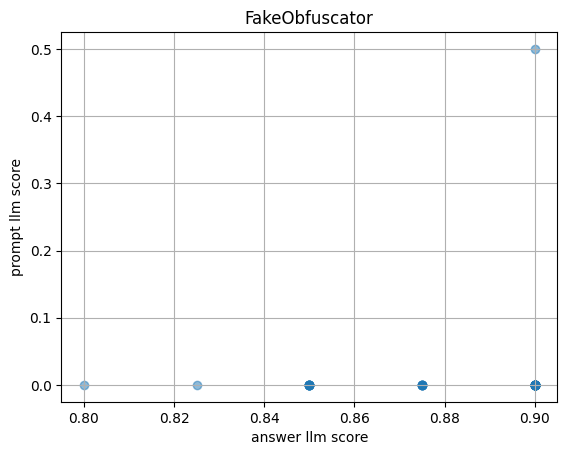

ContextReletiveObfuscator
50
Correlation between answer llm score and prompt llm score: 0.0376120860251382


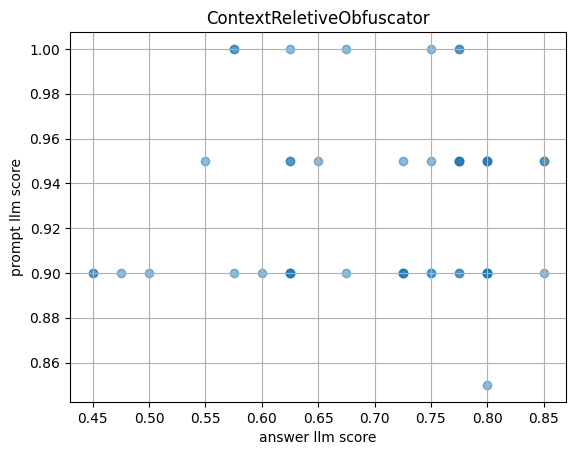

DictionaryObfuscator
50
Correlation between answer llm score and prompt llm score: -0.05974687536878071


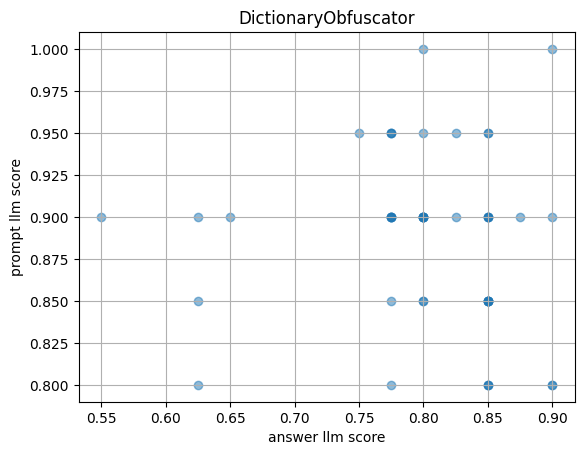

In [126]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

# Define the path to the JSON file
file_name_dict={
"DICTIONARY RESULT" : "cache_test_RESULT.json"
}
inputfile_path = os.path.join(os.getenv("PROJECT_PATH"), "data", "28-08-2024")

for name, path in file_name_dict.items():
    new_inputfile_path = os.path.join(inputfile_path, path)

    with open(new_inputfile_path, 'r', encoding='utf-8') as file:
        data = json.load(file)

    # Extract prompt_metric and answer_metric into a DataFrame
    metrics = []

    similarity_columns = ['answer llm score', 'prompt llm score']

    for obfuscator in data:
        print (obfuscator[0])
        metrics = []
        for dict_index in obfuscator[1]:
            # if dict_index["answer_metric"]["llm similarity"] == 0.4 and obfuscator[0]=="FewPromptsObfuscator":
            #     print(dict_index)
            metrics.append({
                'answer llm score': dict_index['answer_metric']['llm_similarity'],
                'prompt llm score': dict_index['prompt_metric']['llm_similarity']
            })
        
        df = pd.DataFrame(metrics)
        print(len(df))
        for i in range(len(similarity_columns)):
            for j in range(i+1, len(similarity_columns)):
                correlation = df[similarity_columns[i]].corr(df[similarity_columns[j]])
                print(f"Correlation between {similarity_columns[i]} and {similarity_columns[j]}: {correlation}")

                plt.clf()   
                plt.scatter(df[similarity_columns[i]], df[similarity_columns[j]], alpha=0.5)
                plt.title(f'{obfuscator[0]}')
                plt.xlabel(similarity_columns[i])
                plt.ylabel(similarity_columns[j])
                plt.grid(True)

                name = f"scatter_plot_{obfuscator[0]}_{similarity_columns[i]}_{similarity_columns[j]}.png"
                output_path = os.path.join(os.getenv("PROJECT_PATH"), "data", "20-08-2024", "prompt embedding to llm answer correlation",name)            
                plt.show()


ContextReletiveObfuscator
DictionaryObfuscator
Correlation between DictionaryObfuscator - answer score and DictionaryObfuscator - prompt score: -0.0020062514106461192


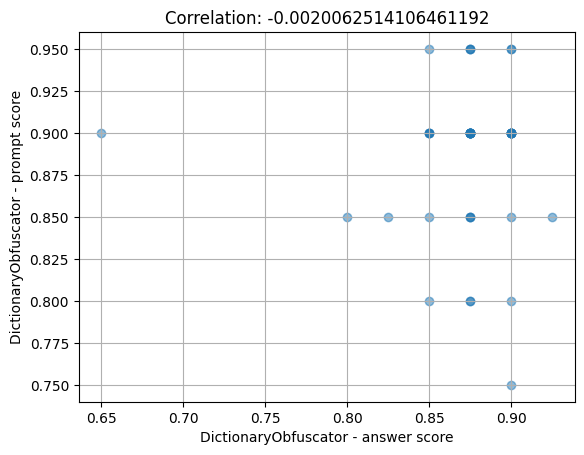

In [61]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

# Define the path to the JSON file
file_name_dict={
"DICTIONARY RESULT" : "FINANCE_RESULT.json"
}
inputfile_path = os.path.join(os.getenv("PROJECT_PATH"), "data", "September-2024","2024-09-02")

for name, path in file_name_dict.items():
    new_inputfile_path = os.path.join(inputfile_path, path)

    with open(new_inputfile_path, 'r', encoding='utf-8') as file:
        data = json.load(file)

    # Extract prompt_metric and answer_metric into a DataFrame
    metrics = []

    ContextReletiveObfuscator_score = ['ContextReletiveObfuscator - answer score', 'ContextReletiveObfuscator - prompt score']
    DictionaryObfuscator_score = ['DictionaryObfuscator - answer score', 'DictionaryObfuscator - prompt score']

    list_of_metrics = []

    for obfuscator in data[1:3]:
        print (obfuscator[0])
        metrics = []
        for dict_index in obfuscator[1]:
            if obfuscator[0] == "ContextReletiveObfuscator":
                metrics.append({
                    'ContextReletiveObfuscator - answer score': dict_index['answer_metric']['llm_similarity'],
                    'ContextReletiveObfuscator - prompt score': dict_index['prompt_metric']['llm_similarity']
                })
            if obfuscator[0] == "DictionaryObfuscator":
                metrics.append({
                    'DictionaryObfuscator - answer score': dict_index['answer_metric']['llm_similarity'],
                    'DictionaryObfuscator - prompt score': dict_index['prompt_metric']['llm_similarity']
                })
        list_of_metrics.append(metrics)
    
    context_df = pd.DataFrame(list_of_metrics[0])
    dictionary_df = pd.DataFrame(list_of_metrics[1])
    df = pd.concat([context_df, dictionary_df], axis=1)
    output_excel_path = os.path.join(os.getenv("PROJECT_PATH"), "data", "September-2024", "01", "metrics.xlsx")
    # df.to_excel(output_excel_path, index=True)



    # print(len(df))
    # for i in range(len(ContextReletiveObfuscator_score)):
    #     for j in range(len(DictionaryObfuscator_score)):
    #         correlation = df[ContextReletiveObfuscator_score[i]].corr(df[DictionaryObfuscator_score[j]])
    #         name = f"Correlation between {ContextReletiveObfuscator_score[i]} and {DictionaryObfuscator_score[j]}"
    #         print(name + f": {correlation}")

    #         plt.clf()   
    #         plt.scatter(df[ContextReletiveObfuscator_score[i]], df[DictionaryObfuscator_score[j]], alpha=0.5)
    #         plt.title(f'Correlation: {correlation}')
    #         plt.xlabel(ContextReletiveObfuscator_score[i])
    #         plt.ylabel(DictionaryObfuscator_score[j])
    #         plt.grid(True)

    #         output_path = os.path.join(os.getenv("PROJECT_PATH"), "data", "September-2024" , "01", f"{name}.png")     
    #         plt.savefig(output_path)  # Save the plot       
    #         plt.show()

    for i in range(len(ContextReletiveObfuscator_score)):
        for j in range(i+1,len(ContextReletiveObfuscator_score)):
            correlation = df[ContextReletiveObfuscator_score[i]].corr(df[ContextReletiveObfuscator_score[j]])
            name = f"Correlation between {ContextReletiveObfuscator_score[i]} and {ContextReletiveObfuscator_score[j]}"
            print(name + f": {correlation}")

            plt.clf()   
            plt.scatter(df[ContextReletiveObfuscator_score[i]], df[ContextReletiveObfuscator_score[j]], alpha=0.5)
            plt.title(f'Correlation: {correlation}')
            plt.xlabel(ContextReletiveObfuscator_score[i])
            plt.ylabel(ContextReletiveObfuscator_score[j])
            plt.grid(True)

            output_path = os.path.join(os.getenv("PROJECT_PATH"), "data", "September-2024" , "2024-09-02", f"{name}.png")     
            plt.savefig(output_path)  # Save the plot       
            plt.show()


In [170]:
from colorama import Fore, Back, Style
inputfile_path = os.path.join(os.getenv("PROJECT_PATH"), "data", "28-08-2024")
new_inputfile_path = os.path.join(inputfile_path, "cache_test_RESULT.json")

with open(new_inputfile_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

for obfuscator in data:
    print (obfuscator[0])
    if obfuscator[0] != "DictionaryObfuscator":
        continue
    for index, case_dict in enumerate(obfuscator[1]):
        if case_dict["answer_metric"]["llm_similarity"] <=0.55:
            i = 0
            print(Fore.GREEN + f"Index: {index}")
            for key, value in case_dict.items():
                print(Fore.YELLOW + f"{key}: {value}") if i%2==0 else print(Fore.CYAN + f"{key}: {value}")
                i +=1
            print("__________________________________")

FakeObfuscator
ContextReletiveObfuscator
DictionaryObfuscator
Index: 44
original_prompt: In the dynamic world of finance, *median income* plays a crucial role in determining economic stability, particularly in regions like *Kerala* and *Shanghai*. Educational institutions such as *McGill University faculty* often engage in research to understand the impact of incomes on public health, which can, in turn, influence investments in *therapeutic drugs* and *blood testing*. Moreover, historical events, such as the *promotion to Liga 4* and the initiatives at the *International Centre for Free and Open Source Software*, also shape economic policies. As a *head coach* or a financial advisor, one must gauge the economic landscape considering various actors including *Indian politicians*, athletes like those in the *Calgary Stampeders*, and even cultural figures like *Lou Holtz*. 

**Question: How does the fluctuation in the median income in regions such as Kerala and Shanghai impact the invest

In [69]:
from colorama import Fore, Back, Style

from colorama import Fore, Back, Style
new_inputfile_path = os.path.join(inputfile_path, "wiki_combined_results.json")

with open(new_inputfile_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

for data_case in data:
    name = data_case[0]
    obfuscator_data = data_case[1]
    for index, case_dict in enumerate(obfuscator_data):
        # if index == 20:
        if  case_dict["answer_metric"]["llm_similarity"] <=0.5 and index != 20:
            i = 0
            print(Fore.GREEN + f"name: {name},   Index: {index}, prompt grade : {case_dict['prompt_metric']['llm_similarity']}, answer grade : {case_dict['answer_metric']['llm_similarity']}")
            for key, value in case_dict.items():
                print(Fore.YELLOW + f"{key}: {value}") if i%2==0 else print(Fore.CYAN + f"{key}: {value}")
                i +=1
            print("__________________________________")

name: Azure - Questions,   Index: 14, prompt grade : 0.8, answer grade : 0.3
original_prompt: Richard Anthony Cerri, known as Dick Cerri (June 1, 1936 – October 3, 2013) was a well known American folk music disc jockey in Washington, D.C. between 1960 and 1995.

Cerri was born in Utica, New York on June 1, 1936, the younger of two children of Dominick J. Cerri and his wife Mildred May Isaac.  Cerri started out in high school as an announcer in Utica on WIBX-AM and moved to ABC affiliate WRUN-AM (see WUTI) where he remained through college.  He graduated in 1959 from Utica College.

He moved to Washington, D.C. in 1960 and soon after was employed at WAVA-FM, where he created the show "Music Americana, the Folk Music of America."  Cerri hosted and produced at several area radio stations, including WHFS-FM and WJMD-FM which changed call sign to WLTT-FM (see WIAD) where the name of his show was shortened to "Music Americana."   He was at WETA-FM from 1970 to 1973 where his brother Bill was

In [124]:
import requests
from datasets import load_dataset
import os
# Disable SSL verification (not recommended for production)
crt_path = os.path.join(os.getenv("PROJECT_PATH"),"ca-certificates.crt")
os.environ["REQUESTS_CA_BUNDLE"]= crt_path
# load_dataset("wikipedia", "20220301.en", trust_remote_code=True)

wiki_data = load_dataset("wikipedia", "20220301.en")





In [146]:
wiki_data["train"][0]

{'id': '12',
 'url': 'https://en.wikipedia.org/wiki/Anarchism',
 'title': 'Anarchism',
 'text': 'Anarchism is a political philosophy and movement that is sceptical of authority and rejects all involuntary, coercive forms of hierarchy. Anarchism calls for the abolition of the state, which it holds to be unnecessary, undesirable, and harmful. As a historically left-wing movement, placed on the farthest left of the political spectrum, it is usually described alongside communalism and libertarian Marxism as the libertarian wing (libertarian socialism) of the socialist movement, and has a strong historical association with anti-capitalism and socialism.\n\nHumans lived in societies without formal hierarchies long before the establishment of formal states, realms, or empires. With the rise of organised hierarchical bodies, scepticism toward authority also rose. Although traces of anarchist thought are found throughout history, modern anarchism emerged from the Enlightenment. During the latte

In [147]:

data = []
i =0
for index, case in enumerate(wiki_data["train"].shuffle(seed=42).select(range(1000))):
    if len(case["text"]) <= 3000 and len(case["text"]) >= 1500:
        data.append(case)
        i += 1
print(i)

195


In [150]:
with open("wiki_data_set.json", 'w') as file:
    json.dump(data, file, indent=4)

In [2]:
import json
with open("wiki_data_set.json", 'r') as file:
    data = json.load(file)

In [4]:
from src.utils.azure_client import get_answer
prompt = "summerize the following text in two sentences:\n"

new_data = []

for index, case in enumerate(data[:100]):
    print(index)
    new_data.append({
        "original_prompt" : prompt + case["text"],
        "original_answer" : get_answer(prompt + case["text"])
    })

with open("wiki_data_Q&A_set.json", 'w') as file:
    json.dump(new_data, file, indent=4)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [1]:
import os
import json
with open(os.path.join("data","21-08-2024","wiki_data_W&S_set.json"), 'r') as file:
    data = json.load(file)
    

In [3]:
from src.utils.azure_client import get_answer
new_data = []
for case in data[:50]:
    prompt_and_question = get_answer("write a question on the following text:\n" + case["original_prompt"].strip("summerize the following text in two sentences:\n"))
    new_case = {
        "original_prompt": case["original_prompt"].strip("summerize the following text in two sentences:\n") + "\n" + prompt_and_question
    }
    new_case["original_answer"] = get_answer(new_case["original_prompt"])
    new_data.append(new_case)

with open(os.path.join("data","22-08-2024","wiki_data_W&Q_set.json"), 'w') as file:
    json.dump(new_data,file,indent=4)

In [46]:
new_data

[{'original_prompt': "write a question on the following text:\nCheryl S. McWatters is professor and Father Edgar Thivierge Chair in Business History at the Telfer School of Management, University of Ottawa.\n\nEducation and career\nShe was previously a professor at the University of Alberta and associate professor at McGill University. McWatters is a qualified accountant and earned her B.A., M.B.A. and Ph.D. all from Queen's University, Kingston, Ontario. Her work relates primarily to seventeenth and eighteenth century international trading networks. She is a trustee and former president of the Academy of Accounting Historians. McWatters established the Geraldine Grace and Maurice Alvin McWatters Visiting Fellowship at Queen's University in memory of her parents.\n\nEditing\nMcWatters is editor of Accounting History Review and associate editor of the Journal of Operations Management and Accounting Perspectives. She serves on the editorial boards of Accounting, Auditing and Accountabili

In [21]:
with open(os.path.join("data","22-08-2024","wiki_data_W&Q_set.json"), 'w') as file:
    json.dump(new_data,file,indent=4)

In [34]:
new_new_data = []
for case in new_data[:50]:
    new_case = {
        "original_prompt": case["original_prompt"],
        "original_prompt_question": case["original_answer"],
        "original_answer": get_answer(case["original_prompt"] + "\n" + case["original_answer"])
    }
    new_new_data.append(new_case)

with open(os.path.join("data","21-08-2024","wiki_data_W&Q_set2.json"), 'w') as file:
    json.dump(new_new_data,file,indent=4)

In [33]:
for case in new_new_data[:50]:
    case["original_prompt"] = case["original_prompt"] + case["original_prompt_question"]
    case.pop("original_prompt_question")
    new_new_data.append(new_case)


KeyError: 'original_prompt_question'

In [36]:
with open(os.path.join("data","21-08-2024","wiki_data_W&Q_set2.json"), 'r') as file:
    data = json.load(file)

In [37]:
new_data = []
for case in data[:50]:
    new_case = {
        "original_prompt": case["original_prompt"] + case["original_prompt_question"],
        "original_answer": case["original_answer"] 
    }
    new_data.append(new_case)

In [39]:
with open(os.path.join("data","21-08-2024","wiki_data_W&Q_set3.json"), 'w') as file:
    json.dump(new_data,file,indent=4)

In [23]:
from src.utils.azure_client import get_answer
a = get_answer("hello")
a

In [78]:
file_name_dict={
"Azure - Questions" : "wiki_W&Q_azure_RESULTS.json",
"Ollama - Question" : "wiki_W&Q_ollama_RESULTS.json",
"Azure - Summery" : "wiki_W&S_azure_RESULTS.json",
"Ollama - Summery" : "wiki_W&S_ollama_RESULTS.json",
}
inputfile_path = os.path.join(os.getenv("PROJECT_PATH"), "data", "phase-1-results")

final_dict = {}

for name, path in file_name_dict.items():
    new_inputfile_path = os.path.join(inputfile_path, path)

    with open(new_inputfile_path, 'r', encoding='utf-8') as file:
        data = json.load(file)

    for case in data[0][1]:
        if "Note that I" not in case["obfuscated_prompt"]:
            final_dict.update(case["obfuscated_dictonary"])

    with open(os.path.join(os.getenv("PROJECT_PATH"),"data","23-08-2024","combined_dict.json"), 'w', encoding = 'utf-8') as file:
        json.dump(final_dict,file,indent=4, ensure_ascii=False)

In [109]:
from src.utils.azure_client import get_answer, get_embedding
import os
import json
import random


input_ath = os.path.join(os.getenv("PROJECT_PATH"),"data","23-08-2024","combined_dict.json")
with open(input_ath, 'r', encoding='utf-8') as file:
        combined_dict = json.load(file)

data = []

prompt = """
Given the following list, write me a short paragraph and a question finance-related that uses most of the words in the list.
List:
{lst}
"""

# prompt = """
# Generate a finance-related short paragraph and question using terms from the list:
# List:
# {lst}
# """
faulty_count = 0
for j in range(120):
        print(j)
        sample_keys = random.sample(list(combined_dict.keys()), 50)
        original_prompt = get_answer(prompt.format(lst=sample_keys), temp=1)
        
        key_count = sum(1 for key in sample_keys if key in original_prompt)
        if key_count < 10:
            faulty_count += 1
            print(key_count)
            continue

        original_answer = get_answer(original_prompt)
        dictonary_used = {key: combined_dict[key] for key in sample_keys}
        original_prompt_embedding = get_embedding(original_prompt)
        original_answer_embedding = get_embedding(original_answer)

        data.append({
                "original_prompt": original_prompt,
                "original_answer": original_answer,
                "obfuscated_dictonary": dictonary_used,
                "original_prompt_embedding": original_prompt_embedding,
                "original_answer_embedding": original_answer_embedding
        })
with open(os.path.join(os.getenv("PROJECT_PATH"),"data","23-08-2024","generated_data_set_on.json"), 'w', encoding = 'utf-8') as file:
        json.dump(data,file,indent=4, ensure_ascii=False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


In [119]:
input_ath = os.path.join(os.getenv("PROJECT_PATH"),"data","23-08-2024","generated_data_set_on.json")

with open(input_ath, 'r', encoding='utf-8') as file:
        data = json.load(file)

print(type(data))
# with open(os.path.join(os.getenv("PROJECT_PATH"),"data","23-08-2024","generated_data_set_on2.json"), 'w', encoding = 'utf-8') as file:
#         json.dump(data,file,indent=4, ensure_ascii=False)

<class 'list'>


In [178]:
from src.Evaluators.llm_embedding_and_precentage_of_change_evaluator import GPTEmbeddingAndPChangedEvaluator

evaluator = GPTEmbeddingAndPChangedEvaluator()

prompt= """
Texas A&M recently collaborated with a popular American heavy metal band to host a fundraising event in an art gallery located near Farnborough. The event was geared towards raising money for creating open spaces and cultural projects at Milton Creek Country Park. Investors from Orlando and Australia contributed through a partnership that launched a FOSS initiative. Additionally, funds were allocated for the restoration of historic sites like Lazimpat Durbar and to enhance the amenities at Clifton park and museum and Bough Beech Reservoir. The plan includes building up the infrastructure to host international art collections and soundtracks, as well as organizing photometric observations and scientific expeditions. As a general manager from Sambenedettese, I've previously seen how these types of investments can boost local populations and provide educational opportunities, benefiting the community's overall economy.\n\nHow can similar finance-based strategies used in cultural and communal projects at Texas A&M be implemented in other regions like India or Recife to improve local infrastructure and foster economic growth?
"""
original_case =    {
        "original_prompt": "Texas A&M recently collaborated with a popular American heavy metal band to host a fundraising event in an art gallery located near Farnborough. The event was geared towards raising money for creating open spaces and cultural projects at Milton Creek Country Park. Investors from Orlando and Australia contributed through a partnership that launched a FOSS initiative. Additionally, funds were allocated for the restoration of historic sites like Lazimpat Durbar and to enhance the amenities at Clifton park and museum and Bough Beech Reservoir. The plan includes building up the infrastructure to host international art collections and soundtracks, as well as organizing photometric observations and scientific expeditions. As a general manager from Sambenedettese, I've previously seen how these types of investments can boost local populations and provide educational opportunities, benefiting the community's overall economy.\n\nHow can similar finance-based strategies used in cultural and communal projects at Texas A&M be implemented in other regions like India or Recife to improve local infrastructure and foster economic growth?",
        "original_answer": "Implementing finance-based strategies similar to those used in cultural and communal projects at Texas A&M in regions like India or Recife can significantly improve local infrastructure and foster economic growth. Here are some steps and strategies to consider:\n\n### 1. **Public-Private Partnerships (PPPs)**\n- **Engage Local and International Investors:** Just as Texas A&M collaborated with investors from Orlando and Australia, regions in India or Recife can attract both local and international investors. Highlight the potential returns on investment and the social impact of the projects.\n- **Government Support:** Secure support from local and national governments to provide incentives such as tax breaks or subsidies to attract private investments.\n\n### 2. **Community Involvement and Stakeholder Engagement**\n- **Local Community Engagement:** Involve local communities in the planning and execution of projects to ensure they meet the needs and preferences of the residents. This can be done through public consultations, surveys, and town hall meetings.\n- **Cultural Relevance:** Ensure that the projects reflect and preserve local culture and heritage, which can increase community support and participation.\n\n### 3. **Diversified Funding Sources**\n- **Crowdfunding and Donations:** Utilize crowdfunding platforms to raise small amounts of money from a large number of people. This can be particularly effective for cultural and community projects.\n- **Grants and Philanthropy:** Apply for grants from international organizations, NGOs, and philanthropic foundations that support cultural and community development.\n\n### 4. **Leveraging Technology and Innovation**\n- **FOSS Initiatives:** Implement Free and Open Source Software (FOSS) initiatives to reduce costs and increase accessibility to technology. This can be particularly useful in educational and cultural projects.\n- **Digital Platforms:** Use digital platforms to promote projects, attract investments, and engage with the community. Virtual tours, online exhibitions, and social media campaigns can increase visibility and support.\n\n### 5. **Educational and Research Collaborations**\n- **Partnerships with Educational Institutions:** Collaborate with local universities and research institutions to conduct scientific expeditions, photometric observations, and other research activities. This can provide educational opportunities and attract academic funding.\n- **Internships and Training Programs:** Create internships and training programs for local students and professionals to build skills and increase employment opportunities.\n\n### 6. **Sustainable and Inclusive Development**\n- **Environmental Sustainability:** Ensure that projects are environmentally sustainable, such as by incorporating green spaces, renewable energy sources, and eco-friendly materials.\n- **Inclusive Development:** Focus on inclusive development that benefits all segments of the population, including marginalized and underrepresented groups.\n\n### 7. **Marketing and Promotion**\n- **Cultural Tourism:** Promote cultural and historical sites to attract tourists. Develop marketing campaigns that highlight the unique cultural and historical aspects of the region.\n- **Events and Festivals:** Organize cultural events, festivals, and exhibitions to draw visitors and create a vibrant cultural scene.\n\n### 8. **Monitoring and Evaluation**\n- **Performance Metrics:** Establish clear performance metrics to monitor the progress and impact of the projects. This can include economic indicators, community satisfaction surveys, and environmental impact assessments.\n- **Continuous Improvement:** Use the data collected to make informed decisions and continuously improve the projects.\n\n### Case Study Application\n- **India:** In India, similar strategies can be applied to projects like the restoration of historical sites, development of cultural hubs, and creation of green spaces in urban areas. For example, the restoration of heritage sites in Rajasthan or the development of cultural centers in cities like Bangalore and Mumbai.\n- **Recife:** In Recife, these strategies can be used to enhance the city's cultural heritage, improve public spaces, and promote cultural tourism. Projects could include the restoration of historical buildings in the Old Town, development of waterfront parks, and organization of cultural festivals.\n\nBy adopting these strategies, regions like India and Recife can leverage cultural and communal projects to improve local infrastructure, foster economic growth, and enhance the quality of life for their residents.",
        "obfuscated_dictonary": {
            "Texas A&M": "🤠🏫",
            "Castles": "🏰🔥💎",
            "FOSS": "🤖💸",
            "art gallery": "🎨👀",
            "Farnborough": "🏙️✈️",
            "Sal Maglie": "👤⚾11",
            "American heavy metal band": "🤘🎸",
            "MA": "📚💡",
            "Infantry 026": "🔫👥🔴",
            "Orlando": "🎥🕰️",
            "Australia": "🇦🇺",
            "CD": "📀🔊",
            "Milton Creek Country Park": "🌳🌊",
            "right arm medium pace": "⏱️🔴🌪️",
            "Omar Migineishvili": "🧤⚽",
            "Lazimpat Durbar": "🏛️🏘️",
            "dining room": "🍴👩‍🍳",
            "Dick Cerri": "🧔🎤",
            "auditorium": "🏢🎤",
            "popular_vote1": "📊🗳️",
            "Bough Beech Reservoir": "🌊🏞️",
            "monogrammed initials": "🔒🕰️👀",
            "Wsitqamu": "🌲🏞️",
            "AFC U-20 Women's Championship": "🏅👧🌏",
            "Clifton park and museum": "🏞️🏛️",
            "Recife": "🌆🇧🇷1️⃣",
            "open spaces": "🏃‍♀️🌄",
            "Eleanor": "👩‍🎨👯‍♀️",
            "tissues": "👨‍⚕️🏥",
            "pumpkinseed": "🎃️🌼",
            "India": "🇮🇳",
            "national election": "🗳️🏛️🕰️",
            "photometric observations": "📸🔭",
            "population": "👥📈",
            "Member of the Legislative Assembly": "🏃‍♂️🏆🗳️",
            "soundtrack": "🎵🔊💃",
            "footballer": "⚽️👟",
            "2010 census": "📅🔢",
            "Sambenedettese": "🌊⚽",
            "limbo": "🔮🕳️💀",
            "anemia of chronic disease": "🩸🛠️",
            "general manager": "💼🔧",
            "new wave": "🌊🔊",
            "New York Central Railroad": "🗽🚂🛤️",
            "Jorge Sebastián Matías Lagües Suárez": "🧑⚽🇨🇱",
            "P.J. Savoy": "🏀🎯",
            "coastal scenes": "🌊🏖️🎨",
            "partnership": "💼️👥📈",
            "Assists": "⚫️💪",
            "Puerto Rico's largest restaurant chain": "🏆🇵🇷🏢"
        },
        "original_prompt_embedding": [
            0.013086410239338875,
            0.010566983371973038,
            0.030671272426843643,
            0.05707777664065361,
            -0.009318225085735321,
            0.020914888009428978,
            0.030028637498617172,
            0.03370919078588486,
            -0.03963897004723549,
            -0.007094557397067547,
            -0.0010671047493815422,
            -0.056698039174079895,
            -0.04767192155122757,
            -0.05488697439432144,
            0.02891862951219082,
            0.04892798140645027,
            -0.032628390938043594,
            -0.03356313705444336,
            -0.028436651453375816,
            0.02406964637339115,
            0.0117208082228899,
            0.0443711094558239,
            -0.04542269557714462,
            -0.002902816981077194,
            -0.034527089446783066,
            -0.033241819590330124,
            -0.01889934577047825,
            0.03683473914861679,
            -0.01307180430740118,
            -0.027735594660043716,
            -0.003914238419383764,
            -0.030992591753602028,
            -0.02012619748711586,
            0.0275019071996212,
            -0.06946313381195068,
            0.04206345975399017,
            -0.008624469861388206,
            -0.021849630400538445,
            0.004250162281095982,
            0.004122365266084671,
            0.0035454530734568834,
            -0.025165049359202385,
            0.0188263189047575,
            0.01372174359858036,
            0.02542794495820999,
            0.007171235512942076,
            -0.05707777664065361,
            0.0034267844166606665,
            0.014247536659240723,
            0.05021325498819351,
            0.006462875287979841,
            -0.03943449258804321,
            0.016270380467176437,
            -0.05687330290675163,
            -0.007131070829927921,
            0.0018320608651265502,
            0.0024737841449677944,
            -0.014568855054676533,
            -0.00808407086879015,
            -0.018373552709817886,
            0.02605597674846649,
            -0.009449672885239124,
            0.07805109024047852,
            0.029824161902070045,
            -0.01340772770345211,
            0.0680025964975357,
            -0.031167855486273766,
            -0.00719314394518733,
            -0.010150730609893799,
            0.03563709929585457,
            -0.009296316653490067,
            0.012575222179293633,
            -0.019133031368255615,
            -0.0289770495146513,
            -0.04355320706963539,
            -0.041333191096782684,
            -0.010362508706748486,
            -0.015817614272236824,
            -0.005243327002972364,
            -0.014313261024653912,
            0.00719314394518733,
            -0.03210259974002838,
            0.0034048764500766993,
            0.008142492733895779,
            0.01472221128642559,
            0.0294590275734663,
            -0.030729694291949272,
            -0.008105979301035404,
            -0.07723318785429001,
            0.01505813468247652,
            0.023835960775613785,
            0.039872653782367706,
            -0.035841573029756546,
            0.012954961508512497,
            0.04574401304125786,
            0.02687387727200985,
            -0.008843550458550453,
            -0.008967695757746696,
            0.048665087670087814,
            0.04288136214017868,
            -0.010150730609893799,
            -0.0428229384124279,
            0.020257646217942238,
            -0.03668868541717529,
            0.015700770542025566,
            0.009610332548618317,
            0.023631485179066658,
            0.00015506792988162488,
            0.06309518963098526,
            -0.008887366391718388,
            -0.0870479941368103,
            -0.04787639528512955,
            0.015963668003678322,
            0.04165450856089592,
            -0.033271029591560364,
            -0.04241398721933365,
            -0.05503302812576294,
            -0.02810072898864746,
            0.0429689921438694,
            0.012166271917521954,
            -0.05894726514816284,
            0.02964889630675316,
            -0.042034249752759933,
            0.04168372228741646,
            0.03426419198513031,
            -0.02890402264893055,
            -0.042589254677295685,
            -0.041946616023778915,
            -0.03823685273528099,
            -0.05120642110705376,
            0.018358947709202766,
            0.005937082227319479,
            0.015700770542025566,
            0.011275344528257847,
            -0.0050059896893799305,
            -0.02357306331396103,
            -0.04559795930981636,
            -0.002552288118749857,
            -0.03417656198143959,
            -0.019249875098466873,
            0.0349944606423378,
            0.0090626310557127,
            0.008325059898197651,
            0.01738038845360279,
            0.009551910683512688,
            -0.03800316900014877,
            -0.0033975737169384956,
            -0.020023958757519722,
            0.011779229156672955,
            0.01878250390291214,
            -0.012684762477874756,
            -0.02877257578074932,
            -0.027224406599998474,
            0.0027877995744347572,
            -0.013787467032670975,
            -0.023938197642564774,
            -0.04442952945828438,
            0.008901971392333508,
            0.009917045012116432,
            -0.019848695024847984,
            0.005097273271530867,
            0.027691777795553207,
            -0.022375423461198807,
            0.009836715646088123,
            -0.011983704753220081,
            0.041917406022548676,
            -0.06081675365567207,
            -0.03362155705690384,
            -0.07799266278743744,
            -0.0036093515809625387,
            -0.07624001801013947,
            -0.06122570484876633,
            -0.012305022217333317,
            0.04434189572930336,
            -0.008850852958858013,
            -0.051440104842185974,
            -0.0349944606423378,
            -0.037331320345401764,
            0.015014318749308586,
            -0.010435535572469234,
            -0.05035930871963501,
            -0.03151838481426239,
            -0.03800316900014877,
            0.03417656198143959,
            -0.055325135588645935,
            0.05526671186089516,
            -0.017906181514263153,
            -0.007609396707266569,
            0.019118426367640495,
            0.08389323204755783,
            -0.018505001440644264,
            0.03017469123005867,
            0.042676884680986404,
            0.03896712139248848,
            -0.04895719513297081,
            -0.0337384007871151,
            0.01471490878611803,
            0.02088567614555359,
            0.021995684131979942,
            -0.008332362398505211,
            -0.03554946556687355,
            -0.01691301539540291,
            0.036542631685733795,
            -0.03481919690966606,
            -0.015321031212806702,
            0.00706169568002224,
            -0.015540111809968948,
            0.028641127049922943,
            0.03271602466702461,
            0.004126016516238451,
            0.036046046763658524,
            -0.00833966489881277,
            0.033300239592790604,
            0.018285920843482018,
            0.028538888320326805,
            -0.007320940960198641,
            -0.03633815422654152,
            0.054770130664110184,
            -0.03511130437254906,
            -0.02271134778857231,
            -0.003382968483492732,
            0.013626808300614357,
            -0.017175912857055664,
            0.02424491010606289,
            -0.001792808878235519,
            0.039901863783597946,
            -0.05415670573711395,
            -0.021761998534202576,
            0.029269156977534294,
            -0.04504295438528061,
            0.014196418225765228,
            -0.01374365109950304,
            -0.06332887709140778,
            -0.031781282275915146,
            -0.01605129987001419,
            -0.009113749489188194,
            -0.005550039932131767,
            -0.04034002497792244,
            0.0013993767788633704,
            -0.02079804427921772,
            0.023821355774998665,
            -0.023061877116560936,
            0.05301748588681221,
            0.029371395707130432,
            -0.047993239015340805,
            0.0415668785572052,
            -0.03776948153972626,
            -0.011523635126650333,
            0.03800316900014877,
            0.07647370547056198,
            -0.0160220880061388,
            0.020023958757519722,
            -0.02136765420436859,
            -0.019030794501304626,
            -0.027399670332670212,
            -0.0241426732391119,
            -0.0733189508318901,
            -0.014700302854180336,
            -0.05988200753927231,
            -0.03493604063987732,
            0.0031109433621168137,
            0.0022492266725748777,
            -0.039171598851680756,
            -0.011603964492678642,
            -0.02821757085621357,
            -0.017321966588497162,
            -0.016255775466561317,
            0.010837183333933353,
            -0.021031729876995087,
            0.04095345363020897,
            0.020301461219787598,
            0.009770991280674934,
            -0.020520541816949844,
            -0.0685868114233017,
            0.02014080248773098,
            -0.007032484747469425,
            0.033183395862579346,
            0.004038384184241295,
            0.015335636213421822,
            -0.008558745495975018,
            -0.04025239497423172,
            -0.038499750196933746,
            -0.051294051110744476,
            -0.0061415573582053185,
            -0.004578782711178064,
            0.0417129322886467,
            0.017745522782206535,
            0.012451075948774815,
            -0.03134312108159065,
            -0.0029283761978149414,
            0.028422046452760696,
            -0.04358241707086563,
            -0.0026563513092696667,
            -0.03537420183420181,
            0.026567164808511734,
            -0.025121232494711876,
            -0.018256710842251778,
            -0.045977700501680374,
            -0.02019922435283661,
            0.016401829198002815,
            0.019206058233976364,
            -0.010880999267101288,
            -0.04971667379140854,
            0.01599287800490856,
            0.02269674278795719,
            -0.005042503122240305,
            0.007755450438708067,
            -0.05257932469248772,
            0.00739761907607317,
            0.003141979919746518,
            0.044517163187265396,
            0.017993813380599022,
            -0.015043528750538826,
            -0.03283286839723587,
            -0.03572472929954529,
            0.03972660005092621,
            0.04404979199171066,
            -0.014634578488767147,
            -0.0009475232800468802,
            -0.016971437260508537,
            -0.0361044704914093,
            -0.021791208535432816,
            0.009157565422356129,
            -0.03674710541963577,
            0.0034906829241663218,
            -0.03645499795675278,
            0.033095765858888626,
            -0.015087345615029335,
            -0.04761350154876709,
            -0.011012447997927666,
            0.047350604087114334,
            0.002745809266343713,
            0.004290326964110136,
            -0.002555939368903637,
            -0.01372174359858036,
            0.02085646614432335,
            0.0457732230424881,
            -0.017263544723391533,
            0.05839226022362709,
            -0.01673775166273117,
            -0.04209266975522041,
            -0.044517163187265396,
            -0.03020390123128891,
            0.03738974407315254,
            0.026421111077070236,
            0.007981834001839161,
            -0.037857115268707275,
            0.038587383925914764,
            -0.019016189500689507,
            0.05257932469248772,
            0.012633643113076687,
            -0.013312793336808681,
            0.015101950615644455,
            0.02893323451280594,
            0.008850852958858013,
            0.005933430977165699,
            0.029166920110583305,
            -0.022302396595478058,
            -0.05284222215414047,
            -0.008880063891410828,
            -0.023207928985357285,
            0.030612852424383163,
            0.060758329927921295,
            -0.012713972479104996,
            0.03738974407315254,
            0.031284697353839874,
            -0.062102023512125015,
            -0.024420175701379776,
            0.02269674278795719,
            -0.08219901472330093,
            0.0055719478987157345,
            0.022375423461198807,
            -0.000434737914474681,
            0.003298987401649356,
            0.002716598566621542,
            0.03744816407561302,
            0.06502310186624527,
            0.027764804661273956,
            0.03487762063741684,
            0.031956546008586884,
            0.025807686150074005,
            -0.02555939368903637,
            0.03411813825368881,
            -0.011151198297739029,
            -0.0021141269244253635,
            0.029999425634741783,
            0.02203950099647045,
            -0.035958416759967804,
            0.015729980543255806,
            0.05228721722960472,
            0.01673775166273117,
            -0.047204550355672836,
            -0.016299590468406677,
            0.030379164963960648,
            0.004848982207477093,
            -0.023762933909893036,
            0.03306655213236809,
            0.012122455053031445,
            0.06163465231657028,
            -0.009215987287461758,
            -0.022945033386349678,
            -0.006210932973772287,
            -0.04288136214017868,
            0.0068754767999053,
            0.0442250557243824,
            0.03493604063987732,
            0.003914238419383764,
            0.01608050987124443,
            -0.05561724305152893,
            -0.06052464619278908,
            -0.0023514642380177975,
            -0.06695100665092468,
            0.036571841686964035,
            0.03400129824876785,
            -0.012553313747048378,
            0.023251745849847794,
            -0.03201496601104736,
            -0.0016303241718560457,
            -0.023076482117176056,
            -0.02205410599708557,
            0.004622599110007286,
            -0.0001676194224273786,
            0.052024319767951965,
            -0.013707137666642666,
            0.016358012333512306,
            0.026318874210119247,
            0.001935211243107915,
            -0.009654148481786251,
            -0.03566630929708481,
            -0.07729160785675049,
            -0.04302741587162018,
            -0.007850385271012783,
            0.019863300025463104,
            0.02963429130613804,
            -0.008646378293633461,
            0.023792143911123276,
            0.037857115268707275,
            -0.0010442838538438082,
            0.008230124600231647,
            -0.006375242955982685,
            0.009712569415569305,
            0.03338786959648132,
            -0.009259803220629692,
            0.02674242854118347,
            -0.04372847080230713,
            0.01246568188071251,
            0.04959983006119728,
            0.05152773857116699,
            -0.003822955070063472,
            0.024945968762040138,
            0.008354270830750465,
            -0.022536082193255424,
            0.01606590487062931,
            0.017862364649772644,
            0.06256939470767975,
            0.011560148559510708,
            0.02423030510544777,
            0.02693229913711548,
            0.0538938082754612,
            -0.017000649124383926,
            0.025238076224923134,
            0.002603406785055995,
            0.05961911380290985,
            -0.00940585695207119,
            0.009004209190607071,
            -0.05027167871594429,
            -0.03692236915230751,
            -0.0014988759066909552,
            0.019293691962957382,
            -0.02218555472791195,
            -0.020476726815104485,
            0.026684006676077843,
            -0.041888196021318436,
            0.03438103571534157,
            -0.01603669486939907,
            0.0035673610400408506,
            0.013838586397469044,
            -0.03096337988972664,
            -0.0038740739692002535,
            -0.045831646770238876,
            -0.02481452003121376,
            -0.015583927743136883,
            -0.07419527322053909,
            0.005853101145476103,
            -0.003976311534643173,
            -0.03140154108405113,
            0.02282818965613842,
            -0.01539405807852745,
            -0.057311464101076126,
            0.016591697931289673,
            0.010968631133437157,
            -0.006006457842886448,
            0.02820296585559845,
            -0.01805223524570465,
            0.00553543446585536,
            -0.031226277351379395,
            -0.03353392332792282,
            -0.008142492733895779,
            0.04489690065383911,
            0.0033793170005083084,
            0.004100457299500704,
            -0.014583460055291653,
            -0.009690661914646626,
            0.0010607148287817836,
            0.01683998852968216,
            0.0022291443310678005,
            -0.015101950615644455,
            -0.011100079864263535,
            0.00018530560191720724,
            0.020549753680825233,
            0.023120297119021416,
            -0.010026585310697556,
            -0.0021871537901461124,
            0.026669401675462723,
            0.02402583137154579,
            0.03622131422162056,
            -0.0275019071996212,
            0.03163522854447365,
            0.01539405807852745,
            0.010252968408167362,
            -0.008354270830750465,
            0.023207928985357285,
            -0.01448122225701809,
            0.010457444004714489,
            -0.006999622564762831,
            -0.0035162423737347126,
            -0.02894783951342106,
            -0.04495532438158989,
            -0.008427297696471214,
            -0.01382398046553135,
            -0.005714350380003452,
            -0.022565294057130814,
            0.02408425137400627,
            0.017132095992565155,
            0.009340132586658001,
            -0.04291057214140892,
            0.0042574647814035416,
            -0.03160601481795311,
            -0.024463990703225136,
            -0.006046622525900602,
            0.008953090757131577,
            0.010924815200269222,
            -0.0030671271961182356,
            -0.023894382640719414,
            -0.023587670177221298,
            -0.0137509535998106,
            -0.039171598851680756,
            0.013619505800306797,
            -0.00807676836848259,
            -0.009617635048925877,
            0.060057274997234344,
            -0.01876789890229702,
            0.009559213183820248,
            -0.014875567518174648,
            0.01887013576924801,
            0.004932963289320469,
            0.017278149724006653,
            -0.025968344882130623,
            -0.014174509793519974,
            0.0009151176200248301,
            0.014254839159548283,
            -0.04805166274309158,
            -0.018928557634353638,
            -0.01818368397653103,
            0.02351464331150055,
            0.03096337988972664,
            -0.009581121616065502,
            0.01881171390414238,
            -0.005243327002972364,
            0.009968163445591927,
            -0.010866394266486168,
            -0.056639619171619415,
            -0.004450985696166754,
            -0.0337384007871151,
            0.01887013576924801,
            0.036542631685733795,
            -0.03963897004723549,
            -0.04048607870936394,
            0.038645803928375244,
            0.00013897920143790543,
            -0.01605129987001419,
            0.003025136888027191,
            -0.007163933012634516,
            0.021148573607206345,
            -0.012180876918137074,
            -0.02141146920621395,
            -0.007058043964207172,
            0.008755918592214584,
            0.02402583137154579,
            -0.01007040124386549,
            -0.02605597674846649,
            -0.020272251218557358,
            0.011793835088610649,
            0.005279840435832739,
            0.001452321303077042,
            0.014101482927799225,
            -0.0031328515615314245,
            0.01936671882867813,
            0.009026117622852325,
            0.0431150458753109,
            -0.013086410239338875,
            -0.014751422218978405,
            -0.04553953930735588,
            -0.010786063969135284,
            -0.000881799089256674,
            0.0029448072891682386,
            0.0043231891468167305,
            -0.043991368263959885,
            0.0028736062813550234,
            0.03163522854447365,
            0.03213180974125862,
            0.01803763024508953,
            0.015890641137957573,
            -0.02215634286403656,
            -0.03613368049263954,
            -0.028334414586424828,
            -0.006466526538133621,
            0.011362976394593716,
            0.022287791594862938,
            0.02611439861357212,
            -0.027954675257205963,
            -0.01873868703842163,
            0.011136593297123909,
            0.009865926578640938,
            0.047438234090805054,
            0.03353392332792282,
            0.010815274901688099,
            -0.011041657999157906,
            -0.007974530570209026,
            0.006010109093040228,
            0.00841999426484108,
            0.0069850170984864235,
            -0.015963668003678322,
            -0.024463990703225136,
            -0.03084653802216053,
            -0.012034823186695576,
            -0.017015254124999046,
            0.008974998258054256,
            -0.014305957593023777,
            -0.027794014662504196,
            0.029794950038194656,
            -0.013006079941987991,
            0.037272900342941284,
            -0.03686394914984703,
            0.008142492733895779,
            -0.006937549915164709,
            0.01952737756073475,
            0.019950931891798973,
            0.04962904006242752,
            0.0001816542644519359,
            -0.03283286839723587,
            0.010442838072776794,
            0.0025468110106885433,
            0.012356141582131386,
            0.014583460055291653,
            0.03201496601104736,
            -0.0025011692196130753,
            -0.03490683063864708,
            -0.016956832259893417,
            0.03622131422162056,
            -0.020316066220402718,
            0.018402764573693275,
            -0.044634003192186356,
            0.017190517857670784,
            -0.03292049840092659,
            0.03207338973879814,
            -0.02479991503059864,
            0.03084653802216053,
            0.00800374150276184,
            -0.015525505878031254,
            0.000713837391231209,
            0.006123300641775131,
            0.017687100917100906,
            0.024405570700764656,
            0.01822749897837639,
            0.015321031212806702,
            -0.03534499183297157,
            -0.017876969650387764,
            0.03873343765735626,
            -0.02614360861480236,
            0.007901503704488277,
            0.010026585310697556,
            -0.009807504713535309,
            0.0044911508448421955,
            -0.025033600628376007,
            -0.011311857961118221,
            0.015540111809968948,
            0.012509497813880444,
            4.721071309177205e-05,
            -0.011428700760006905,
            -0.0269469041377306,
            0.011348371393978596,
            0.019454350695014,
            0.0009685184923000634,
            0.029911793768405914,
            0.005856752395629883,
            -0.003976311534643173,
            0.021177783608436584,
            -0.03169364854693413,
            -0.09581121802330017,
            0.018621845170855522,
            -0.012268508784472942,
            0.027180589735507965,
            -0.035257358103990555,
            -0.03347550332546234,
            0.0032423916272819042,
            -0.0064774807542562485,
            -0.007364756893366575,
            0.04697086289525032,
            0.024507807567715645,
            0.009325527586042881,
            -0.03306655213236809,
            0.016431039199233055,
            0.043261099606752396,
            0.004578782711178064,
            0.010698432102799416,
            0.03289128839969635,
            -0.012662854045629501,
            -0.015423269011080265,
            -0.007437783759087324,
            -0.011874164454638958,
            0.02017001248896122,
            0.007474297191947699,
            0.0021123012993484735,
            -0.04174214228987694,
            0.012706669978797436,
            0.007565580774098635,
            -0.005159346386790276,
            -0.0066381399519741535,
            0.005141089670360088,
            -0.019264480099081993,
            0.006919293198734522,
            -0.00014297285815700889,
            -0.01742420345544815,
            -0.02205410599708557,
            -0.0044984533451497555,
            0.0014751421986147761,
            -0.019162243232131004,
            -0.017730917781591415,
            0.0032296120189130306,
            0.026508742943406105,
            -0.008646378293633461,
            0.006999622564762831,
            -0.010618102736771107,
            0.020578963682055473,
            -0.02347082644701004,
            0.007879596203565598,
            0.0014477571239694953,
            0.009873229078948498,
            0.05184905603528023,
            -0.007134722080081701,
            0.014933988451957703,
            -0.0036330854054540396,
            -0.003076255554333329,
            0.009836715646088123,
            0.022536082193255424,
            -0.020009353756904602,
            0.003578315256163478,
            -0.0496874637901783,
            -0.014028456062078476,
            -0.009194078855216503,
            0.017263544723391533,
            0.0013665147125720978,
            0.008865458890795708,
            0.011969098821282387,
            0.04805166274309158,
            0.020535146817564964,
            0.016504066064953804,
            0.011713504791259766,
            -0.059998851269483566,
            0.012597129680216312,
            -0.012991474941372871,
            -0.015744587406516075,
            -0.014904778450727463,
            0.018446579575538635,
            -0.017599469050765038,
            0.0073099867440760136,
            -0.0428229384124279,
            0.005707047414034605,
            -0.0038813764695078135,
            0.021294627338647842,
            -0.0018503175815567374,
            -0.02471228316426277,
            0.0414208248257637,
            -0.0351405143737793,
            -0.0037754876539111137,
            0.02948823757469654,
            0.013875099830329418,
            -0.024945968762040138,
            -0.000931092188693583,
            0.017584864050149918,
            0.008967695757746696,
            0.00040758104296401143,
            -0.007981834001839161,
            0.011859558522701263,
            0.03911317512392998,
            -0.0017964602448046207,
            -0.056639619171619415,
            -0.029911793768405914,
            0.04375768452882767,
            0.008485718630254269,
            -0.006901036482304335,
            -0.013553781434893608,
            0.039931077510118484,
            0.034556299448013306,
            0.04632822796702385,
            0.02482912503182888,
            -0.0017471672035753727,
            -0.009836715646088123,
            -0.002813359024003148,
            0.03277444466948509,
            -0.03680552914738655,
            0.006663699168711901,
            -0.03613368049263954,
            0.004925660323351622,
            0.025647025555372238,
            0.03554946556687355,
            -0.0228135846555233,
            -0.018008418381214142,
            -0.005352867301553488,
            -0.0010433709248900414,
            0.0039288438856601715,
            -0.017102885991334915,
            -0.013685230165719986,
            0.03508209437131882,
            -0.0036130028311163187,
            -0.01406496949493885,
            0.035958416759967804,
            0.03145996108651161,
            -0.007014228031039238,
            -0.007682423572987318,
            0.007346500176936388,
            -0.0035180679988116026,
            0.014342471025884151,
            0.0456271693110466,
            -0.011136593297123909,
            0.019658826291561127,
            -0.0008758656913414598,
            0.011092777363955975,
            0.021177783608436584,
            0.02357306331396103,
            0.04825613647699356,
            -0.009573819115757942,
            -0.002643571700900793,
            0.013970034196972847,
            -0.022623715922236443,
            -0.005466058850288391,
            0.012093245051801205,
            -0.00038247808697633445,
            -0.0040931543335318565,
            0.005122832953929901,
            -0.0036622961051762104,
            -0.02205410599708557,
            0.0003708394360728562,
            -0.008755918592214584,
            0.02411346323788166,
            -0.021338442340493202,
            -0.008310454897582531,
            0.01755565218627453,
            -0.006623534485697746,
            -0.015087345615029335,
            -0.028407441452145576,
            0.03227786347270012,
            -0.008113281801342964,
            0.012655551545321941,
            -0.017745522782206535,
            -0.003950751852244139,
            0.010778761468827724,
            -0.00720774894580245,
            -0.014758724719285965,
            -0.0034724262077361345,
            0.0025413341354578733,
            -0.010092309676110744,
            -0.012356141582131386,
            0.04112871736288071,
            0.009340132586658001,
            -0.034527089446783066,
            0.016971437260508537,
            0.006097740959376097,
            0.0064847832545638084,
            0.014035758562386036,
            -0.019688036292791367,
            -0.0041990433819592,
            -0.001501614460721612,
            0.0010570634622126818,
            -0.006952155381441116,
            0.04305662587285042,
            -0.013604900799691677,
            -0.0031529339030385017,
            0.022974243387579918,
            -0.008704799227416515,
            0.03280365839600563,
            0.021119361743330956,
            -0.0010077704209834337,
            -0.0027622401248663664,
            0.013166739605367184,
            -0.021177783608436584,
            0.0073757111094892025,
            -0.002884560264647007,
            0.007499856408685446,
            -0.034497879445552826,
            -0.0008562396978959441,
            0.0337384007871151,
            -0.006952155381441116,
            -0.00753636984154582,
            -0.009778293780982494,
            -0.04349478706717491,
            0.019264480099081993,
            -0.01681077852845192,
            0.022638320922851562,
            0.004304932430386543,
            0.024259516969323158,
            0.01380937546491623,
            -0.010610800236463547,
            -0.004235556814819574,
            0.03940528258681297,
            -0.004370656330138445,
            0.03163522854447365,
            -0.02071041241288185,
            -0.07016418874263763,
            0.014912080951035023,
            0.02541333995759487,
            -0.02690308727324009,
            -0.01875329203903675,
            0.013561083935201168,
            0.026990721002221107,
            0.025866106152534485,
            0.01754104718565941,
            0.027399670332670212,
            -0.0006677391938865185,
            0.04951219633221626,
            -0.011830348521471024,
            0.006367940455675125,
            0.035783153027296066,
            -0.027852436527609825,
            0.030349954962730408,
            0.003081732662394643,
            0.007463342975825071,
            0.0025212515611201525,
            -0.010822577401995659,
            0.004461939912289381,
            0.035958416759967804,
            -0.000285261106910184,
            -0.022287791594862938,
            0.013283582404255867,
            -0.05585092678666115,
            -0.0015536460559815168,
            -0.001979027409106493,
            -0.0009014250827021897,
            -0.0016385397175326943,
            0.004071246366947889,
            -0.017614074051380157,
            -0.008171703666448593,
            -0.06274466216564178,
            0.010844485834240913,
            -0.01007040124386549,
            0.01272127591073513,
            0.03014547936618328,
            0.008383480831980705,
            -0.010654616169631481,
            0.005188556853681803,
            0.03978502377867699,
            0.011195014230906963,
            -0.011713504791259766,
            -0.0011620395816862583,
            0.05976516753435135,
            -0.0415668785572052,
            0.005046154838055372,
            -0.04521821811795235,
            0.009785596281290054,
            0.011969098821282387,
            0.004480196628719568,
            -0.03896712139248848,
            0.022930428385734558,
            -0.006492086220532656,
            0.028319809585809708,
            0.0068134041503071785,
            -0.011216922663152218,
            -0.0004411277477629483,
            0.0181252621114254,
            0.02469767816364765,
            0.0013875099830329418,
            -0.01246568188071251,
            -0.0077189370058476925,
            0.002552288118749857,
            0.014006547629833221,
            -0.04314425587654114,
            -0.03382603079080582,
            0.02471228316426277,
            0.017774732783436775,
            0.01943974569439888,
            -0.048694297671318054,
            -0.015759192407131195,
            -0.0014349773991852999,
            0.01879710890352726,
            0.011034355498850346,
            -0.022448450326919556,
            -0.03201496601104736,
            -0.014780632220208645,
            0.037944745272397995,
            0.035169728100299835,
            -0.021192388609051704,
            0.018592633306980133,
            -0.0030196597799658775,
            -0.006546856369823217,
            -0.014955896884202957,
            -0.03400129824876785,
            0.005316353868693113,
            -0.014335168525576591,
            -0.04551032558083534,
            0.010296784341335297,
            0.05690251290798187,
            -0.016328802332282066,
            -0.021294627338647842,
            0.023164113983511925,
            -0.05628908798098564,
            -0.02423030510544777,
            -0.04773034155368805,
            -0.009924347512423992,
            -0.039931077510118484,
            -0.009559213183820248,
            -0.011479819193482399,
            0.02136765420436859,
            -0.009822109714150429,
            -0.03379682078957558,
            -0.05027167871594429,
            0.004063943866640329,
            0.02290121652185917,
            0.05176142603158951,
            0.028714153915643692,
            0.022536082193255424,
            -0.012129758484661579,
            -0.006451921537518501,
            -0.023719117045402527,
            0.007364756893366575,
            0.0014742293860763311,
            -0.0033227212261408567,
            0.017161307856440544,
            -0.017657890915870667,
            -0.031051011756062508,
            -0.021995684131979942,
            -0.04069055616855621,
            -0.025048205628991127,
            0.014627275988459587,
            -0.000739396782591939,
            0.021163178607821465,
            -0.010537773370742798,
            -0.007090906146913767,
            0.02560321055352688,
            0.008047557435929775,
            -0.020418304949998856,
            0.0035016369074583054,
            0.02950284443795681,
            0.04413742199540138,
            0.020578963682055473,
            0.005696093663573265,
            0.017833154648542404,
            -0.0032350891269743443,
            -0.0026636540424078703,
            0.0262458473443985,
            0.009274409152567387,
            -0.0013035291340202093,
            -0.012166271917521954,
            -0.025340313091874123,
            -0.009026117622852325,
            0.02276976965367794,
            0.005115529987961054,
            0.009201382286846638,
            -0.03738974407315254,
            0.010033887811005116,
            -0.002691039117053151,
            0.009800202213227749,
            0.007967228069901466,
            -0.02151370793581009,
            -0.022477662190794945,
            -0.016416434198617935,
            -0.0030178341548889875,
            -0.010888301767408848,
            0.02406964637339115,
            0.010311390273272991,
            0.0030379164963960648,
            -0.002860826440155506,
            -0.009968163445591927,
            0.01669393479824066,
            -0.021586734801530838,
            -0.02287200652062893,
            0.035257358103990555,
            -0.028582705184817314,
            0.009427765384316444,
            0.01513116154819727,
            -0.027808621525764465,
            -0.0013035291340202093,
            -0.0028918629977852106,
            0.023310167714953423,
            -0.006108695175498724,
            0.003939798101782799,
            -0.021995684131979942,
            -0.00553178321570158,
            0.02824678272008896,
            0.003969008568674326,
            -0.006722120568156242,
            -0.009800202213227749,
            -0.003581966506317258,
            -0.0004009630065411329,
            -0.008602561429142952,
            0.017906181514263153,
            -0.016401829198002815,
            0.0032058781944215298,
            0.05923937261104584,
            -0.025340313091874123,
            0.01008500624448061,
            0.0009224202949553728,
            0.015452479012310505,
            -0.0281299389898777,
            -0.00941315945237875,
            -0.01621195860207081,
            -0.031051011756062508,
            -0.00805486086755991,
            -0.02084186114370823,
            0.023982014507055283,
            0.01941053383052349,
            -0.013780164532363415,
            -0.023689907044172287,
            -0.004629901610314846,
            -0.007251565344631672,
            -0.014437406323850155,
            0.014933988451957703,
            -0.014203720726072788,
            0.031810492277145386,
            -0.02018461935222149,
            0.01872408203780651,
            -0.029999425634741783,
            0.036630261689424515,
            0.014211023226380348,
            -0.027764804661273956,
            -0.031927336007356644,
            -0.017234334722161293,
            0.018607238307595253,
            -0.014897475019097328,
            -0.00719314394518733,
            -0.0026527000591158867,
            -0.009128355421125889,
            0.0016376269049942493,
            -0.017920786514878273,
            -0.03557867556810379,
            0.04168372228741646,
            0.01813986711204052,
            0.06981366127729416,
            -0.02402583137154579,
            0.016284985467791557,
            -0.0005928866448812187,
            0.0028188361320644617,
            -0.010924815200269222,
            -0.004151575732976198,
            0.020549753680825233,
            -0.010325995273888111,
            -0.011100079864263535,
            -0.02276976965367794,
            0.013524570502340794,
            -0.0017216077540069818,
            -0.03365076705813408,
            -0.0057399095967411995,
            0.002477435627952218,
            -0.04241398721933365,
            0.0060648792423307896,
            0.008712101727724075,
            -0.021659761667251587,
            -0.016562487930059433,
            -0.003673250088468194,
            -0.009186776354908943,
            0.013254371471703053,
            -0.00023003455135039985,
            -0.006824358366429806,
            0.033884454518556595,
            0.02279897965490818,
            -0.022506872192025185,
            -0.028626522049307823,
            0.012582524679601192,
            0.015817614272236824,
            -0.0014441057574003935,
            0.019658826291561127,
            -0.031284697353839874,
            -0.012933053076267242,
            -0.006433664821088314,
            -0.012151665985584259,
            0.029970215633511543,
            -0.01479523815214634,
            -0.015671560540795326,
            -0.03487762063741684,
            -0.000953000271692872,
            -0.023310167714953423,
            0.0020885677076876163,
            0.012085942551493645,
            0.012283114716410637,
            -0.02205410599708557,
            0.02075422741472721,
            0.0075509753078222275,
            -0.01755565218627453,
            -0.009960860945284367,
            -0.0032752538099884987,
            -0.016372617334127426,
            -0.007430480793118477,
            0.0017535570077598095,
            -0.013495360501110554,
            0.01691301539540291,
            0.013940824195742607,
            -0.003961706068366766,
            0.035228148102760315,
            -0.02829059772193432,
            -0.03029153309762478,
            -0.035198938101530075,
            -0.021776603534817696,
            -0.0031876214779913425,
            0.004925660323351622,
            0.010932117700576782,
            0.05015483498573303,
            0.009157565422356129,
            -0.031080223619937897,
            0.021995684131979942,
            0.04884035140275955,
            0.013575689867138863,
            0.021820420399308205,
            -0.001526260981336236,
            0.02627505734562874,
            -0.009763688780367374,
            -0.02612900361418724,
            -0.03803237900137901,
            -0.014700302854180336,
            0.008025649935007095,
            0.0003251976449973881,
            -0.010355206206440926,
            -0.02677164040505886,
            0.000423327466705814,
            0.03300813212990761,
            -0.018665660172700882,
            0.023762933909893036,
            0.03163522854447365,
            0.02484373189508915,
            -0.02411346323788166,
            0.0046554612927138805,
            0.009113749489188194,
            -0.023149508982896805,
            0.01755565218627453,
            -0.020023958757519722,
            0.004410821013152599,
            0.03753579780459404,
            -0.003653167746961117,
            0.02611439861357212,
            0.021177783608436584,
            -0.023631485179066658,
            0.027092957869172096,
            -0.023660697042942047,
            -0.003006880171597004,
            -0.028670337051153183,
            0.014430103823542595,
            -0.01609511487185955,
            -0.0021615945734083652,
            0.016664724797010422,
            0.02276976965367794,
            -0.0017334746662527323,
            -0.020257646217942238,
            -0.021090151742100716,
            0.04624059423804283,
            0.0019370369846001267,
            -0.02285740152001381,
            -0.04375768452882767,
            -0.005447802133858204,
            0.003979962784796953,
            0.006276656873524189,
            0.02678624540567398,
            -0.030057847499847412,
            0.019702641293406487,
            0.02079804427921772,
            0.007171235512942076,
            -0.03160601481795311,
            0.014284050092101097,
            0.03885027766227722,
            0.040632132440805435,
            0.03134312108159065,
            -0.0023459873627871275,
            0.01615353673696518,
            -0.005031549371778965,
            -0.011779229156672955,
            0.021776603534817696,
            0.006824358366429806,
            0.045305851846933365,
            0.026377294212579727,
            -0.02677164040505886,
            0.03087574802339077,
            0.01313752867281437,
            0.0048234229907393456,
            0.006123300641775131,
            -0.011129290796816349,
            -0.011333765462040901,
            0.008149795234203339,
            -0.0037334971129894257,
            0.009610332548618317,
            -0.02022843435406685,
            -0.001859445939771831,
            -0.005462407600134611,
            0.03166443854570389,
            0.015671560540795326,
            0.01341503020375967,
            0.0296050813049078,
            -0.01673775166273117,
            -0.0337384007871151,
            0.005016943905502558,
            0.00026997108943760395,
            0.028378229588270187,
            -0.04612375423312187,
            -0.027998490259051323,
            0.008157097734510899,
            -0.051352474838495255,
            -0.013254371471703053,
            0.05214116349816322,
            -0.002977669471874833,
            -0.022463055327534676,
            -0.01819828897714615,
            -0.007923412136733532,
            -0.005827541928738356,
            -0.030057847499847412,
            -0.013247068971395493,
            -0.0055755991488695145,
            0.012940356507897377,
            -0.021791208535432816,
            -0.020374488085508347,
            0.006159814074635506,
            0.01448852475732565,
            -0.01943974569439888,
            -0.008996906690299511,
            0.0057435608468949795,
            0.019016189500689507,
            0.004965825006365776,
            0.007390316110104322,
            -0.007244262378662825,
            0.011866861954331398,
            0.003479728940874338,
            -0.010325995273888111,
            -0.0442250557243824,
            -0.020651990547776222,
            0.009924347512423992,
            0.004681020509451628,
            0.01675235666334629,
            0.002475610002875328,
            -0.021776603534817696,
            -0.026552559807896614,
            -0.02884560264647007,
            -0.033183395862579346,
            -0.022536082193255424,
            -0.0018630973063409328,
            0.014678395353257656,
            -0.018534211441874504,
            -0.0036349110305309296,
            -0.01739499345421791,
            -0.007299032527953386,
            -0.006780541967600584,
            0.020914888009428978,
            0.0015216968022286892,
            -0.0006348770693875849,
            0.005122832953929901,
            0.0026161866262555122,
            0.0017426030244678259,
            -0.026567164808511734,
            -0.013349306769669056,
            0.020476726815104485,
            0.007174887228757143,
            -0.007609396707266569,
            0.008244730532169342,
            -0.041245561093091965,
            0.031197065487504005,
            -0.05181984603404999,
            -0.005316353868693113,
            0.020637385547161102,
            0.03438103571534157,
            -0.004706579726189375,
            -0.02951744943857193,
            0.006229189690202475,
            0.008522232063114643,
            -0.004794212058186531,
            -0.0014696652069687843,
            0.045335061848163605,
            -0.0010095960460603237,
            0.002294868463650346,
            -0.041303981095552444,
            -0.011538241058588028,
            -0.035841573029756546,
            0.016445644199848175,
            0.01746802031993866,
            0.009201382286846638,
            0.0403108149766922,
            -0.002630791859701276,
            -0.011487121693789959,
            -0.010121519677340984,
            0.024960573762655258,
            -2.4418350221822038e-05,
            -0.009785596281290054,
            -0.019658826291561127,
            0.002510297577828169,
            -0.002913770964369178,
            -0.017263544723391533,
            -0.0036933324299752712,
            0.0018649229314178228,
            -0.017263544723391533,
            0.0064701782539486885,
            -0.023675302043557167,
            -0.015321031212806702,
            0.014043061062693596,
            0.0030379164963960648,
            -0.008865458890795708,
            -0.009610332548618317,
            -0.013108317740261555,
            -0.014970501884818077,
            0.031313907355070114,
            0.0274288821965456,
            0.006941201165318489,
            -0.008821642026305199,
            0.013334700837731361,
            -0.01803763024508953,
            0.0010862742783501744,
            0.005082668270915747,
            -0.0036568189971148968,
            -0.021163178607821465,
            0.015817614272236824,
            0.034673143178224564,
            0.03367997705936432,
            0.013765559531748295,
            -0.009310922585427761,
            0.02138225920498371,
            -0.019060004502534866,
            -0.027779409661889076,
            -0.005696093663573265,
            0.005382078234106302,
            0.010325995273888111,
            -0.018636450171470642,
            0.015437874011695385,
            0.016284985467791557,
            0.016431039199233055,
            0.015277215279638767,
            -0.014985107816755772,
            -0.02623124048113823,
            -0.008660983294248581,
            0.017175912857055664,
            -0.01816907711327076,
            0.0026198378764092922,
            -0.02008238062262535,
            0.021236205473542213,
            -0.006587021052837372,
            -0.009632240049540997,
            0.004293978214263916,
            0.010552378371357918,
            -0.029064683243632317,
            0.02357306331396103,
            -0.0031200717203319073,
            -0.0019425139762461185,
            0.04898640513420105,
            -0.019804880023002625,
            -0.004954871255904436,
            -0.006232840940356255,
            0.00020881112141069025,
            -0.02493136376142502,
            0.01206403411924839,
            0.0014632752863690257,
            0.007631304673850536,
            0.03505288437008858,
            0.011779229156672955,
            -0.048781927675008774,
            0.007163933012634516,
            0.004929311573505402,
            0.02221476472914219,
            -0.0009630414424464107,
            -0.026552559807896614,
            0.020476726815104485,
            0.006039319559931755,
            -0.010654616169631481,
            -0.029225341975688934,
            -0.018957767635583878,
            -0.012027520686388016,
            0.007850385271012783,
            0.024653861299157143,
            -0.006499388720840216,
            -0.005856752395629883,
            0.018665660172700882,
            -0.01407957449555397,
            -0.01610972173511982,
            0.016650119796395302,
            -0.011669688858091831,
            -0.017760127782821655,
            0.04177135229110718,
            -0.0031145948451012373,
            -0.031138645485043526,
            0.017292756587266922,
            0.023207928985357285,
            0.0032314376439899206,
            -0.0008503062999807298,
            0.023018060252070427,
            -0.019731853157281876,
            -0.0031511082779616117,
            0.027983885258436203,
            0.004644507076591253,
            -0.013648716732859612,
            0.0031145948451012373,
            -0.030729694291949272,
            0.011311857961118221,
            0.031781282275915146,
            0.017760127782821655,
            0.015876034274697304,
            0.007901503704488277,
            0.0010835357243195176,
            -0.005922476761043072,
            0.0018658357439562678,
            0.025092022493481636,
            -0.004082200583070517,
            0.025296498090028763,
            -0.009011511690914631,
            0.010654616169631481,
            0.0015326507855206728,
            -0.0141379963606596,
            -0.04886956140398979,
            0.04241398721933365,
            0.055967770516872406,
            0.006258400157094002,
            -0.02347082644701004,
            -0.05146931856870651,
            -0.04848982021212578,
            0.03619210049510002,
            -0.011808440089225769,
            -0.04384531453251839,
            -0.005360170267522335,
            -0.026333479210734367,
            -0.019176848232746124,
            -0.005769120529294014,
            -0.0013053547590970993,
            0.006134254392236471,
            -0.0173511765897274,
            0.03966818004846573,
            0.007105511613190174
        ],
        "original_answer_embedding": [
            0.03072279691696167,
            0.014356564730405807,
            0.05576828122138977,
            0.05466296523809433,
            -0.0034289956092834473,
            0.0029030279256403446,
            0.01283047255128622,
            0.03167738765478134,
            -0.01239713840186596,
            0.03838465362787247,
            0.007310166489332914,
            -0.05074411258101463,
            -0.04217790439724922,
            -0.06501275300979614,
            0.07184562087059021,
            0.01966962404549122,
            -0.0426049567759037,
            -0.016830967739224434,
            -0.004807502031326294,
            0.04484071210026741,
            0.05441175401210785,
            0.03971606120467186,
            -0.038158565759658813,
            0.012089408002793789,
            -0.026628097519278526,
            -0.04247935488820076,
            -0.017295703291893005,
            0.09038481116294861,
            -0.006110646296292543,
            -0.03456628695130348,
            0.015172991901636124,
            -0.017936285585165024,
            -0.05295474827289581,
            0.010236745700240135,
            -0.01315076369792223,
            0.03640010952949524,
            -0.056270699948072433,
            -0.015750771388411522,
            0.03863586485385895,
            0.01149278786033392,
            0.01494690403342247,
            -0.02795950323343277,
            0.002196504035964608,
            0.011737716384232044,
            0.0028370856307446957,
            0.006663304753601551,
            -0.04443877935409546,
            -0.009589883498847485,
            0.02019716054201126,
            0.058883264660835266,
            -0.0042768241837620735,
            0.0061294869519770145,
            0.036199141293764114,
            -0.09817226976156235,
            0.01779812015593052,
            -0.026351768523454666,
            0.009891333989799023,
            -0.002538775559514761,
            -0.0254474189132452,
            -0.008698093704879284,
            0.05732577294111252,
            0.02025996334850788,
            0.0753123015165329,
            -0.006663304753601551,
            -0.034088991582393646,
            0.07857801020145416,
            -0.008855098858475685,
            -0.03170251101255417,
            -0.019682183861732483,
            0.013201005756855011,
            0.011392304673790932,
            0.011593271046876907,
            0.012899555265903473,
            -0.02166673168540001,
            -0.018715031445026398,
            -0.04994024336338043,
            5.809195863548666e-05,
            0.03959045559167862,
            0.01641647331416607,
            -0.016780726611614227,
            -0.00430508516728878,
            -0.011115974746644497,
            0.03363681584596634,
            0.03976630046963692,
            -0.013477334752678871,
            0.009250751696527004,
            -0.03338560461997986,
            -0.023990409448742867,
            -0.04840787127614021,
            0.016931451857089996,
            -0.009658966213464737,
            0.027733415365219116,
            -0.0360986590385437,
            0.02587447315454483,
            0.027507327497005463,
            0.003162086708471179,
            -0.008635290898382664,
            -0.013251246884465218,
            0.06430936604738235,
            0.07008716464042664,
            0.021490884944796562,
            -0.02126479707658291,
            0.023651277646422386,
            0.015763331204652786,
            0.03597305342555046,
            0.00215254258364439,
            0.0048169223591685295,
            0.022445477545261383,
            0.028964336961507797,
            -0.010682640597224236,
            -0.08134130388498306,
            -0.02630152739584446,
            0.04413732886314392,
            0.03748030588030815,
            0.017609713599085808,
            -0.040746014565229416,
            -0.04810642451047897,
            -0.06516347825527191,
            0.01690633036196232,
            0.015725649893283844,
            -0.039515092968940735,
            -0.004279964603483677,
            -0.03584744781255722,
            0.020887983962893486,
            -0.007661858573555946,
            -0.05767746642231941,
            -0.004738419782370329,
            -0.01342709269374609,
            -0.011756557039916515,
            -0.08747079223394394,
            0.011040612123906612,
            0.03140106052160263,
            0.01764739491045475,
            -0.02351311407983303,
            -0.018639668822288513,
            -0.011643513105809689,
            -0.04094698280096054,
            0.018438702449202538,
            -0.032456133514642715,
            -0.02765805274248123,
            0.026904428377747536,
            -0.014143036678433418,
            0.002777423709630966,
            0.0639074370265007,
            0.005325619596987963,
            -0.05132189020514488,
            0.010042059235274792,
            -0.018488943576812744,
            0.021038709208369255,
            0.03830929100513458,
            0.004650496877729893,
            -0.00170350749976933,
            -0.0072096833027899265,
            0.007448331452906132,
            -0.0344909243285656,
            -0.047528643161058426,
            -0.019908271729946136,
            0.011329501867294312,
            -0.0063618547283113,
            -0.012924675829708576,
            0.003168366849422455,
            -0.005096391774713993,
            -0.034390438348054886,
            0.005564267747104168,
            -0.010349788703024387,
            -0.013389411382377148,
            -0.07340311259031296,
            -0.025334374979138374,
            -0.05853157490491867,
            0.007291325833648443,
            -0.06290259957313538,
            -0.07827655971050262,
            -0.015939177945256233,
            0.05330643802881241,
            -4.8745238018454984e-05,
            -0.02682906575500965,
            -0.04386099800467491,
            -0.07480988651514053,
            0.017333384603261948,
            0.005671031307429075,
            -0.04431317374110222,
            -0.04044456407427788,
            -0.06320405006408691,
            0.03072279691696167,
            -0.013188445009291172,
            0.03323487937450409,
            -0.03680204227566719,
            -0.00551716610789299,
            -0.0007473452133126557,
            0.05441175401210785,
            -0.022470597177743912,
            0.022257070988416672,
            0.03753054514527321,
            0.02277204766869545,
            -0.034666769206523895,
            -0.014143036678433418,
            0.008346401154994965,
            0.0029140182305127382,
            0.030798159539699554,
            -0.033687055110931396,
            -0.0372542180120945,
            -0.0032657100819051266,
            0.018614547327160835,
            -0.02160392887890339,
            0.029542116448283195,
            -0.04511704295873642,
            -0.025711188092827797,
            0.01896623894572258,
            0.011072013527154922,
            -0.008553648367524147,
            -0.006832870654761791,
            -0.01645415462553501,
            0.01807444915175438,
            0.02645225264132023,
            0.0007599056116305292,
            -0.02479427680373192,
            -0.025635825470089912,
            0.04901077225804329,
            -0.02483195811510086,
            -0.0035514598712325096,
            0.009828531183302402,
            -0.009740608744323254,
            -0.02234499342739582,
            -0.0006594222504645586,
            0.019832909107208252,
            0.040620408952236176,
            -0.03662619739770889,
            -0.003498078091070056,
            0.012660907581448555,
            -0.04913637787103653,
            0.03602329641580582,
            -0.024844517931342125,
            -0.014155597425997257,
            -0.026778822764754295,
            0.031099610030651093,
            -0.042981769889593124,
            0.007448331452906132,
            -0.004518612287938595,
            -0.012792791239917278,
            -0.036902524530887604,
            0.033310241997241974,
            0.032029081135988235,
            0.026376890018582344,
            -0.023500552400946617,
            -0.011574430391192436,
            0.02986868843436241,
            -0.0370783694088459,
            -0.01890343800187111,
            -0.015110190026462078,
            0.040746014565229416,
            0.004414989147335291,
            0.022081224247813225,
            -0.00574011355638504,
            -0.010199064388871193,
            -0.0046285162679851055,
            -0.01945609599351883,
            -0.04403684660792351,
            -0.04624747857451439,
            -0.041600123047828674,
            -0.027457086369395256,
            -0.012491341680288315,
            -0.019895711913704872,
            -0.02682906575500965,
            -0.007963309064507484,
            -0.02013435959815979,
            -0.024543067440390587,
            -0.04320785775780678,
            0.002020658226683736,
            -0.0039439732208848,
            -0.029667720198631287,
            0.029944051057100296,
            0.004484071396291256,
            0.025233890861272812,
            -0.06003882363438606,
            0.0352947898209095,
            -0.014143036678433418,
            0.03243101388216019,
            -0.0008870799210853875,
            0.0076681384816765785,
            -0.02908994071185589,
            -0.028537282720208168,
            -0.016429034993052483,
            -0.010795684531331062,
            0.0190290417522192,
            0.010035778395831585,
            0.023161420598626137,
            0.00211329129524529,
            0.0010134691838175058,
            -0.02500780299305916,
            -0.018162373453378677,
            -0.0104063106700778,
            -0.022508278489112854,
            -0.05021657422184944,
            -0.040218476206064224,
            0.007636737544089556,
            0.0018102710600942373,
            -0.0199208315461874,
            -0.022596202790737152,
            -0.026326648890972137,
            0.03087352216243744,
            0.009263312444090843,
            -0.031903475522994995,
            -0.04534313082695007,
            0.047528643161058426,
            -0.016278309747576714,
            -0.003956533502787352,
            -0.02449282631278038,
            -0.05853157490491867,
            0.044514141976833344,
            -0.0032657100819051266,
            0.03029574267566204,
            -0.013879268430173397,
            0.015034827403724194,
            -0.037580788135528564,
            -0.05411030724644661,
            0.01607734151184559,
            0.03501846268773079,
            -0.00726620526984334,
            -0.023651277646422386,
            -0.025158528238534927,
            -0.03700300678610802,
            -0.03554599732160568,
            0.04137403517961502,
            -0.030094774439930916,
            0.0075425342656672,
            -0.028436798602342606,
            0.00910002738237381,
            -0.03677691891789436,
            -0.026653219014406204,
            -0.018765272572636604,
            0.03167738765478134,
            0.01605222187936306,
            -0.019066723063588142,
            0.057627223432064056,
            -0.04345906525850296,
            0.030496709048748016,
            0.037731513381004333,
            -0.03916339948773384,
            0.044916074723005295,
            0.0009969836100935936,
            -0.04692574217915535,
            -0.02378944307565689,
            0.0030898642726242542,
            0.01438168529421091,
            0.015034827403724194,
            0.0016250048065558076,
            -0.031903475522994995,
            -0.02553534135222435,
            0.0260251984000206,
            0.030672553926706314,
            -0.010808244347572327,
            -0.005598809104412794,
            0.014582651667296886,
            0.04265519976615906,
            -0.02976820431649685,
            0.009225631132721901,
            0.04152476042509079,
            -0.03602329641580582,
            -0.0647113025188446,
            -0.007869105786085129,
            -0.018853196874260902,
            -0.03446580097079277,
            0.023211663588881493,
            0.012799072079360485,
            0.023060938343405724,
            0.007052678149193525,
            -0.050568267703056335,
            -0.023902487009763718,
            0.018237736076116562,
            -0.027984624728560448,
            0.006349293980747461,
            0.024379782378673553,
            -0.019468657672405243,
            0.031200092285871506,
            -0.02697979100048542,
            0.04247935488820076,
            0.0019594260957092047,
            0.031174970790743828,
            0.021654170006513596,
            0.046272601932287216,
            0.013552697375416756,
            -0.0016328550409525633,
            0.004122958984225988,
            -0.02302325703203678,
            0.002395900897681713,
            0.061244625598192215,
            0.031174970790743828,
            -0.052402086555957794,
            -0.00650629960000515,
            0.04057016968727112,
            0.0033096717670559883,
            -0.01958169974386692,
            0.02053629234433174,
            0.03441556170582771,
            0.05973737686872482,
            0.004069577436894178,
            0.015185552649199963,
            0.005309919361025095,
            0.07033837586641312,
            -0.03851025924086571,
            -0.014444487169384956,
            -0.01287443470209837,
            -0.04323297739028931,
            0.01679328642785549,
            0.007014996837824583,
            0.02098846808075905,
            -0.035470638424158096,
            0.015637727454304695,
            -0.011197618208825588,
            -0.03989190608263016,
            -0.021616488695144653,
            -0.04810642451047897,
            0.017546912655234337,
            -0.0034666769206523895,
            -0.010820805095136166,
            0.011329501867294312,
            0.012001484632492065,
            0.029567237943410873,
            -0.0030176418367773294,
            -0.034239716827869415,
            0.025573022663593292,
            -0.009169109165668488,
            0.03195371851325035,
            -0.022357555106282234,
            0.02170441299676895,
            0.03484261408448219,
            0.004813782405108213,
            -0.006663304753601551,
            -0.027030032128095627,
            -0.0860137790441513,
            -0.03916339948773384,
            -0.0008329130942001939,
            0.06064172461628914,
            0.00881113763898611,
            -0.016027100384235382,
            0.025145968422293663,
            0.04541849344968796,
            -0.006613063160330057,
            0.05732577294111252,
            -0.012937236577272415,
            -0.013263807632029057,
            -0.012962357141077518,
            -0.010613557882606983,
            0.03167738765478134,
            -0.014004872180521488,
            0.018036767840385437,
            0.0005110522615723312,
            0.01270486880093813,
            -0.026602977886795998,
            0.02710539475083351,
            -0.01009858027100563,
            0.03421459347009659,
            0.02540973760187626,
            0.04170060530304909,
            0.021553687751293182,
            -0.014846420846879482,
            0.027733415365219116,
            0.005922239739447832,
            0.04845811426639557,
            -0.033008795231580734,
            0.03059719130396843,
            -0.004468370694667101,
            0.04403684660792351,
            0.00934495497494936,
            0.018451262265443802,
            -0.007762341760098934,
            -0.02728123962879181,
            0.009922734461724758,
            0.029969170689582825,
            -0.03444068133831024,
            0.028562404215335846,
            0.025698626413941383,
            -0.03280782699584961,
            0.014155597425997257,
            -0.01446960773319006,
            0.014256080612540245,
            0.02976820431649685,
            0.0007065238314680755,
            -0.020448369905352592,
            -0.023349827155470848,
            0.014318883419036865,
            -0.021151753142476082,
            -0.06968522816896439,
            0.014494729228317738,
            -0.006305332761257887,
            -0.040871620178222656,
            0.016994252800941467,
            -0.03996726870536804,
            -0.027632933109998703,
            0.03406386822462082,
            -0.00016348175995517522,
            0.005815476179122925,
            0.05948616564273834,
            -0.01252274215221405,
            -0.022520840167999268,
            -0.07697027921676636,
            -0.04222814366221428,
            0.03514406457543373,
            0.024379782378673553,
            0.05245232954621315,
            0.050040729343891144,
            -0.004933106247335672,
            -0.02630152739584446,
            0.030773038044571877,
            0.031752750277519226,
            -0.01404255349189043,
            -0.010927568189799786,
            -0.011442545801401138,
            0.006308472715318203,
            0.014130476862192154,
            -0.005526586435735226,
            -0.020234841853380203,
            0.01660487987101078,
            0.008559929206967354,
            0.04137403517961502,
            0.03846001625061035,
            -0.04958855360746384,
            0.007919346913695335,
            -0.00031852448591962457,
            -0.004135519731789827,
            0.008176836185157299,
            0.010255586355924606,
            -0.015110190026462078,
            -0.004597114864736795,
            -0.008063792251050472,
            -0.015210673213005066,
            -0.03323487937450409,
            -0.07762341946363449,
            -0.02274692803621292,
            -0.016027100384235382,
            -0.005981901660561562,
            -0.022106345742940903,
            0.01404255349189043,
            0.029944051057100296,
            -0.0023739200551062822,
            -0.011404864490032196,
            -0.025208771228790283,
            -0.019770106300711632,
            -0.032732464373111725,
            -0.012334336526691914,
            0.02185513637959957,
            -0.003303391393274069,
            0.022106345742940903,
            -0.01620294712483883,
            -0.028964336961507797,
            -0.010519354604184628,
            -0.03295855224132538,
            0.030948884785175323,
            -0.023249344900250435,
            -0.01313820295035839,
            0.038535378873348236,
            -0.03434019908308983,
            0.019506338983774185,
            0.011555589735507965,
            0.030094774439930916,
            0.023035816848278046,
            -0.0021352721378207207,
            -0.01939329504966736,
            -0.0311498511582613,
            0.006883112248033285,
            0.0086227310821414,
            -0.05622045695781708,
            -0.0011846049455925822,
            -0.003028632141649723,
            0.020586535334587097,
            0.04441365972161293,
            0.011700035072863102,
            0.0004396148433443159,
            -0.025208771228790283,
            0.016102463006973267,
            -0.019807787612080574,
            -0.04833251237869263,
            -0.009024664759635925,
            -0.028461920097470284,
            0.025522781535983086,
            0.019569139927625656,
            -0.04496631771326065,
            -0.07104175537824631,
            0.02311117947101593,
            -0.01132322195917368,
            -0.01696913316845894,
            0.006487458944320679,
            -0.0007367473444901407,
            0.012805351987481117,
            -0.020787501707673073,
            -0.033410727977752686,
            -0.013741103932261467,
            0.007724660448729992,
            0.044916074723005295,
            0.0007728585624136031,
            0.0037304458674043417,
            -0.010833365842700005,
            -0.0059944624081254005,
            0.0025230750907212496,
            -0.005250256974250078,
            0.016014540567994118,
            -0.015876375138759613,
            0.01342709269374609,
            -0.0156879685819149,
            0.023839684203267097,
            -0.019267689436674118,
            -0.02866288647055626,
            -0.021289918571710587,
            -0.019744986668229103,
            0.016805846244096756,
            0.0046944585628807545,
            0.010274427011609077,
            -0.022784609347581863,
            -0.0046975985169410706,
            -0.007021276745945215,
            0.025497660040855408,
            0.0015386518789455295,
            0.019267689436674118,
            -0.01571309007704258,
            -0.03557112067937851,
            -0.004543733317404985,
            0.02946675382554531,
            0.003837209427729249,
            0.01752179116010666,
            -0.007272485177963972,
            -0.010481673292815685,
            -0.026326648890972137,
            0.016215506941080093,
            -0.006977315526455641,
            0.0502668172121048,
            0.006933353841304779,
            -0.009457998909056187,
            -0.009527081623673439,
            0.002629838651046157,
            -0.011040612123906612,
            0.018162373453378677,
            -0.004371027462184429,
            -0.00844060443341732,
            -0.019380733370780945,
            -0.015549805015325546,
            -0.00678262859582901,
            -0.0067889089696109295,
            0.010531915351748466,
            -0.0125667043030262,
            -0.02092566527426243,
            0.03125033527612686,
            -0.009828531183302402,
            0.020586535334587097,
            -0.025422297418117523,
            -0.0004694458330050111,
            0.018275417387485504,
            0.030521830543875694,
            0.04192669317126274,
            0.028964336961507797,
            -0.01528603583574295,
            -0.02019716054201126,
            -0.007027557119727135,
            0.022872531786561012,
            0.01764739491045475,
            0.024882199242711067,
            0.007492292672395706,
            -0.01979522779583931,
            -0.010286986827850342,
            -0.03594793379306793,
            0.026552734896540642,
            -0.0018966239877045155,
            0.03516918793320656,
            -0.043258100748062134,
            -0.0028794771060347557,
            -0.012152209877967834,
            0.005595668684691191,
            -0.00260157766751945,
            0.024467704817652702,
            0.0006562821217812598,
            0.0008026895811781287,
            -0.055567312985658646,
            -0.02068701758980751,
            0.03004453331232071,
            0.018137251958251,
            -0.009143988601863384,
            -0.0033536332193762064,
            -0.026100561022758484,
            -0.03976630046963692,
            0.009401476942002773,
            -0.007379248738288879,
            -0.006889392621815205,
            0.004151219967752695,
            -0.006380695383995771,
            0.005162334069609642,
            -0.03197883814573288,
            -0.033260002732276917,
            -0.008044951595366001,
            0.011235298588871956,
            -0.017546912655234337,
            -0.01673048362135887,
            0.0010699911508709192,
            -0.01313820295035839,
            -0.019054163247346878,
            -0.007875385694205761,
            0.00847200583666563,
            0.02022228203713894,
            0.02670346014201641,
            0.02682906575500965,
            -0.027356602251529694,
            -0.12560424208641052,
            0.01915464550256729,
            0.01973242498934269,
            -0.013075401075184345,
            -0.03393826633691788,
            -0.023852244019508362,
            -0.0028904674109071493,
            -0.0030804439447820187,
            0.0071406010538339615,
            0.02740684524178505,
            0.020385567098855972,
            -0.006016443017870188,
            -0.0061797285452485085,
            0.002102300990372896,
            0.0217923354357481,
            -0.0015920336591079831,
            -0.006013303063809872,
            0.030069654807448387,
            0.00695847487077117,
            0.0009757879306562245,
            0.01632855087518692,
            -0.007818863727152348,
            0.014708256348967552,
            0.0012458370765671134,
            -0.028336316347122192,
            -0.03293343260884285,
            0.01480873953551054,
            -0.0018934839172288775,
            -0.008773456327617168,
            0.0022310451604425907,
            0.01930537074804306,
            -0.009049785323441029,
            0.040344081819057465,
            0.00813287403434515,
            -0.005093251820653677,
            0.004631656222045422,
            0.0005781719810329378,
            -0.009451719000935555,
            -0.011059452779591084,
            -0.0023079777602106333,
            0.04330834001302719,
            0.02151600643992424,
            -0.038284171372652054,
            -0.029717963188886642,
            -0.0038277890998870134,
            0.024354660883545876,
            -0.02949187532067299,
            -0.01362805999815464,
            0.00040585867827758193,
            -0.0011806798866018653,
            0.05456247925758362,
            -0.01958169974386692,
            0.010531915351748466,
            0.004782381467521191,
            0.0013549557188525796,
            0.014419366605579853,
            0.033310241997241974,
            -0.019556580111384392,
            -0.012824192643165588,
            -0.055014654994010925,
            -0.0102493055164814,
            -0.011524188332259655,
            0.02206866443157196,
            0.005645910277962685,
            -0.005881418474018574,
            0.023588476702570915,
            0.03873634710907936,
            0.009200510568916798,
            0.020913105458021164,
            -0.005407262593507767,
            -0.007065238431096077,
            -0.020586535334587097,
            -0.012949797324836254,
            -0.016743045300245285,
            0.0057244133204221725,
            0.04119819030165672,
            0.008107753470540047,
            0.022169148549437523,
            -0.010682640597224236,
            -0.0051529137417674065,
            -0.0033347925636917353,
            0.023035816848278046,
            -0.003234309144318104,
            -0.012466220185160637,
            0.04798081889748573,
            -0.02682906575500965,
            -0.014720816165208817,
            0.012070567347109318,
            -0.002224765019491315,
            0.008515967056155205,
            -0.039917025715112686,
            0.007454611361026764,
            0.013841587118804455,
            0.0017851502634584904,
            0.012974917888641357,
            -0.027055153623223305,
            0.029316028580069542,
            0.0026549596805125475,
            -0.06285236030817032,
            0.022181708365678787,
            0.038836829364299774,
            0.013125643134117126,
            0.00489542493596673,
            0.01404255349189043,
            0.031099610030651093,
            -0.01132322195917368,
            0.04371027275919914,
            -0.011844479478895664,
            -0.020611654967069626,
            -0.016529517248272896,
            0.015587485395371914,
            0.004556293599307537,
            -0.007347847800701857,
            -0.01832565851509571,
            -0.03717885538935661,
            -0.009269592352211475,
            0.014155597425997257,
            0.012755109928548336,
            0.005134073086082935,
            -0.037028130143880844,
            0.009470559656620026,
            -0.0012379867257550359,
            0.0016878069145604968,
            -0.015788452699780464,
            -0.0037335860542953014,
            0.004609675612300634,
            -0.01055703591555357,
            -0.008371522650122643,
            0.015537244267761707,
            0.0484832338988781,
            -0.03170251101255417,
            -0.029717963188886642,
            0.02461843006312847,
            0.008421763777732849,
            0.0087797362357378,
            0.03195371851325035,
            -0.006493738852441311,
            -0.02670346014201641,
            0.012654626742005348,
            0.04458950459957123,
            0.03240589424967766,
            0.014758497476577759,
            0.062349941581487656,
            -0.028813611716032028,
            -0.002311117947101593,
            0.021817456930875778,
            -0.01673048362135887,
            0.0463479645550251,
            0.02157880738377571,
            -0.0203227661550045,
            0.004537452943623066,
            -0.005834316834807396,
            0.0014483738923445344,
            0.007335287518799305,
            -0.018978800624608994,
            0.005736973602324724,
            0.0010919718770310283,
            0.014256080612540245,
            0.01998363435268402,
            0.010701481252908707,
            -0.0025968675035983324,
            -0.004377307835966349,
            -0.04431317374110222,
            0.03763103112578392,
            -0.024116013199090958,
            0.017421307042241096,
            -0.021804895251989365,
            0.02697979100048542,
            -0.006408956367522478,
            -0.004499771632254124,
            0.01890343800187111,
            0.003786967834457755,
            -0.02400296926498413,
            0.009640125557780266,
            0.007636737544089556,
            0.004791801795363426,
            0.007184562273323536,
            -0.00905606523156166,
            0.02848704159259796,
            0.006374415010213852,
            -0.01100293081253767,
            0.038259051740169525,
            0.0200087558478117,
            -0.008490846492350101,
            -0.022030983120203018,
            -0.008352681994438171,
            -0.004892284981906414,
            0.027205877006053925,
            -0.023312145844101906,
            0.017144978046417236,
            0.004609675612300634,
            -0.009759449400007725,
            0.0031777871772646904,
            0.011706314980983734,
            0.002372350078076124,
            0.005645910277962685,
            0.03700300678610802,
            -0.012127089314162731,
            0.005881418474018574,
            -0.0016454155556857586,
            -0.011059452779591084,
            -0.028688007965683937,
            -0.014632893726229668,
            0.020800061523914337,
            0.006889392621815205,
            -0.012403418309986591,
            -0.006349293980747461,
            -0.012321775779128075,
            0.020385567098855972,
            -0.0011304381769150496,
            0.029441632330417633,
            0.020272523164749146,
            0.0078879464417696,
            -0.0016925170784816146,
            0.019255129620432854,
            -0.006007022690027952,
            0.03059719130396843,
            -0.02068701758980751,
            0.03524455055594444,
            0.003743006382137537,
            -0.045594338327646255,
            0.013226126320660114,
            0.014997146092355251,
            -0.006751227658241987,
            -0.03446580097079277,
            0.024141134694218636,
            0.0090686259791255,
            -0.012334336526691914,
            0.03167738765478134,
            0.032732464373111725,
            -0.005130933132022619,
            0.03464164957404137,
            -0.014318883419036865,
            0.003969093784689903,
            0.0595364086329937,
            -0.02891409583389759,
            0.010494234040379524,
            -0.006795189343392849,
            0.0049676476046442986,
            0.019142085686326027,
            -0.0010715611279010773,
            -0.014419366605579853,
            0.049613673239946365,
            -0.008428044617176056,
            -0.006223689764738083,
            -0.014620332978665829,
            -0.03574696555733681,
            -0.01832565851509571,
            0.018576866015791893,
            0.013351730071008205,
            -0.002438292372971773,
            0.025924714282155037,
            -0.015851255506277084,
            -0.003347352845594287,
            -0.015022266656160355,
            -0.01994595304131508,
            -0.022998135536909103,
            -0.023161420598626137,
            0.000693963433150202,
            0.01777299866080284,
            -0.03212956339120865,
            -0.014344003982841969,
            0.04235374927520752,
            0.0026204183232039213,
            -0.015474442392587662,
            0.009665246121585369,
            0.04863395914435387,
            -0.049086134880781174,
            -0.014997146092355251,
            -0.039515092968940735,
            -0.0034415561240166426,
            0.037706393748521805,
            0.0036645035725086927,
            -0.014457047916948795,
            0.026753703132271767,
            0.007913067005574703,
            0.021553687751293182,
            -0.006443497259169817,
            -0.019971074536442757,
            0.01890343800187111,
            0.03170251101255417,
            0.018514065071940422,
            -0.012610665522515774,
            -0.0014546540332958102,
            -0.003749286523088813,
            0.009539641439914703,
            0.002242035698145628,
            -0.04411220923066139,
            0.0073980893939733505,
            0.021503444761037827,
            0.01605222187936306,
            0.01681840792298317,
            -0.0689818486571312,
            -0.02485707774758339,
            0.03401362895965576,
            0.0031118448823690414,
            0.017107296735048294,
            -0.008754615671932697,
            -0.04501655697822571,
            -0.023701518774032593,
            0.008716934360563755,
            0.015298595651984215,
            -0.012284094467759132,
            0.05104556307196617,
            -0.017383625730872154,
            0.01936817355453968,
            -0.020586535334587097,
            -0.030069654807448387,
            0.02387736551463604,
            0.018715031445026398,
            -0.042705439031124115,
            0.025083165615797043,
            0.018614547327160835,
            0.00968408677726984,
            -0.04265519976615906,
            -0.014758497476577759,
            -0.07094127684831619,
            -0.001657975954003632,
            -0.01509762927889824,
            0.0052879382856190205,
            -0.06727363169193268,
            -0.006543980911374092,
            -0.023638717830181122,
            -0.00023727426014374942,
            -0.001752179116010666,
            -0.05051802471280098,
            -0.015888936817646027,
            -0.029642600566148758,
            -0.021189434453845024,
            0.06104366108775139,
            -0.0006766928127035499,
            0.01224641315639019,
            -0.024467704817652702,
            -0.00920679047703743,
            0.01269230805337429,
            0.016592320054769516,
            0.012497621588408947,
            0.00940775778144598,
            0.03418947383761406,
            -0.022332433611154556,
            -0.04137403517961502,
            -0.0024084611795842648,
            -0.013163324445486069,
            -0.034088991582393646,
            0.0331595204770565,
            -0.031174970790743828,
            0.015009705908596516,
            -0.020360447466373444,
            -0.022181708365678787,
            0.005755814258009195,
            0.02443002350628376,
            -0.055165380239486694,
            0.003381894202902913,
            0.011009211651980877,
            0.042429111897945404,
            0.02219426818192005,
            0.006443497259169817,
            -0.0076806992292404175,
            0.01605222187936306,
            -0.023073498159646988,
            0.02449282631278038,
            0.014896662905812263,
            -0.018137251958251,
            -0.017672516405582428,
            -0.030898641794919968,
            -0.009721768088638783,
            0.013829026371240616,
            -0.019556580111384392,
            0.023462871089577675,
            -0.016868649050593376,
            -0.0005919099785387516,
            -0.00982225127518177,
            -0.0055077457800507545,
            0.003028632141649723,
            -0.019807787612080574,
            -0.013816466554999352,
            -0.013829026371240616,
            -0.014544970355927944,
            -0.004440109711140394,
            0.02547253854572773,
            0.009847371838986874,
            0.030094774439930916,
            0.008208236657083035,
            -0.02185513637959957,
            -0.002695780945941806,
            -0.022696685045957565,
            -0.02191793918609619,
            0.021566247567534447,
            -0.0021180014591664076,
            0.0008588189957663417,
            0.007102919742465019,
            0.0053570205345749855,
            -0.021013589575886726,
            -0.014909222722053528,
            0.020913105458021164,
            -0.022596202790737152,
            0.02047349140048027,
            0.008666692301630974,
            0.004860884044319391,
            0.017119858413934708,
            -0.006801469251513481,
            0.012089408002793789,
            -0.008817417547106743,
            0.01045027282088995,
            0.012039165943861008,
            -0.02934115007519722,
            -0.0009702927200123668,
            -0.033837780356407166,
            -0.001838532043620944,
            0.0499151237308979,
            -0.008534807711839676,
            0.00034266404691152275,
            0.006013303063809872,
            0.01715753972530365,
            -0.015210673213005066,
            -0.005162334069609642,
            -0.030094774439930916,
            -0.035772085189819336,
            -0.016027100384235382,
            0.0028637766372412443,
            0.027180757373571396,
            0.03295855224132538,
            -0.015198112465441227,
            -0.027356602251529694,
            0.008911620825529099,
            0.006631903816014528,
            -0.03014501743018627,
            0.004518612287938595,
            -0.02427929826080799,
            0.03820880874991417,
            -0.03353632986545563,
            -0.0196068212389946,
            -0.031752750277519226,
            0.03830929100513458,
            -0.0020442090462893248,
            -0.012290374375879765,
            0.0003030202351510525,
            -0.005649050697684288,
            0.028813611716032028,
            -0.0063681346364319324,
            0.004499771632254124,
            0.0014311033301055431,
            0.01614014431834221,
            -0.0029014579486101866,
            -0.010883606970310211,
            -0.004565713927149773,
            0.029944051057100296,
            0.028185591101646423,
            0.07405626028776169,
            -0.020523732528090477,
            -0.017170099541544914,
            0.03361169248819351,
            0.027808777987957,
            -0.012328055687248707,
            -0.021553687751293182,
            0.008986983448266983,
            -0.025083165615797043,
            -0.014557531103491783,
            -0.04097210243344307,
            0.0018244015518575907,
            0.027331482619047165,
            -0.010469113476574421,
            -0.022508278489112854,
            0.011411145329475403,
            -0.0390377976000309,
            0.016768164932727814,
            0.0013635910581797361,
            -0.012014045380055904,
            -0.010626118630170822,
            -0.0037335860542953014,
            0.003341072704643011,
            0.005611369386315346,
            0.005300499033182859,
            0.0005322479410097003,
            0.026803944259881973,
            0.019079282879829407,
            0.015499562956392765,
            -0.008315000683069229,
            -0.000258273707004264,
            -0.0020300785545259714,
            -0.00019851357501465827,
            -0.00022255501244217157,
            -0.02949187532067299,
            0.014205839484930038,
            0.013866707682609558,
            -0.01287443470209837,
            0.05064363032579422,
            -0.004820062778890133,
            -0.025799110531806946,
            -0.029667720198631287,
            0.0046818978153169155,
            -0.02768317423760891,
            -0.00768697913736105,
            0.036073535680770874,
            0.03562135994434357,
            0.004590834956616163,
            0.015336276963353157,
            -0.012114528566598892,
            -0.028411678969860077,
            -0.003567160340026021,
            -0.011109694838523865,
            -0.026075439527630806,
            -0.023224223405122757,
            0.010305827483534813,
            0.0040727173909544945,
            0.008252198807895184,
            0.011486507952213287,
            -0.012529022991657257,
            -0.0052345567382872105,
            -0.0047572604380548,
            -0.02851216122508049,
            -0.0241536945104599,
            -0.0024131713435053825,
            -0.030069654807448387,
            0.009640125557780266,
            -0.00934495497494936,
            0.018401021137833595,
            -0.00695219449698925,
            -0.0484832338988781,
            0.006675865035504103,
            0.028813611716032028,
            0.00850340723991394,
            0.005391561891883612,
            0.018928559496998787,
            0.012083128094673157,
            -0.0021729532163590193,
            -0.030496709048748016,
            -0.04265519976615906,
            -0.02289765328168869,
            0.0031542363576591015,
            -0.018652228638529778,
            -0.02617592364549637,
            -0.027783656492829323,
            -0.0018008507322520018,
            0.04594603180885315,
            -0.012629506178200245,
            0.011015491560101509,
            0.03130057454109192,
            -0.019531458616256714,
            -0.02685418538749218,
            -0.002935999073088169,
            0.010431432165205479,
            -0.017735319212079048,
            0.01542420033365488,
            0.02087542414665222,
            -0.023839684203267097,
            -0.0033975946716964245,
            -0.0005687517113983631,
            0.019506338983774185,
            0.009269592352211475,
            0.0053570205345749855,
            0.037455182522535324,
            -0.02768317423760891,
            -0.016655120998620987,
            -0.0662185549736023,
            0.016290869563817978,
            -0.02436722256243229,
            -0.010199064388871193,
            0.014884102158248425,
            0.01856430619955063,
            0.03336048498749733,
            -0.02277204766869545,
            -0.024995243176817894,
            0.02495756186544895,
            -0.0062645114958286285,
            -0.007354128174483776,
            -0.014268641360104084,
            0.0009632274741306901,
            0.0028637766372412443,
            0.003381894202902913,
            0.01043771207332611,
            0.005184314679354429,
            0.018438702449202538,
            0.012340616434812546,
            -0.0037995281163603067,
            -0.02811022847890854,
            0.00041488648275844753,
            0.029039699584245682,
            0.029994292184710503,
            0.02961747907102108,
            -0.002713051624596119,
            0.04257983714342117,
            -0.028888974338769913,
            -0.011901001445949078,
            0.010092300362884998,
            -0.01224641315639019,
            0.031024247407913208,
            0.0008855098858475685,
            -0.02617592364549637,
            0.02540973760187626,
            0.0025277852546423674,
            0.01801164820790291,
            0.002937569050118327,
            -0.020096678286790848,
            -0.024781715124845505,
            -0.000320094550261274,
            0.004609675612300634,
            0.00940775778144598,
            -0.01777299866080284,
            -0.0090686259791255,
            -0.0029030279256403446,
            0.03142618015408516,
            0.005664750933647156,
            -0.01838845945894718,
            0.02921554632484913,
            0.009049785323441029,
            -0.04011799395084381,
            -0.008723214268684387,
            -0.0250454843044281,
            0.021503444761037827,
            -0.007919346913695335,
            -0.011078293435275555,
            0.018715031445026398,
            -0.04300688952207565,
            -0.004659917205572128,
            0.04446389898657799,
            -0.02378944307565689,
            -0.02808510698378086,
            -0.014620332978665829,
            -0.04235374927520752,
            -0.0034227154683321714,
            -0.014997146092355251,
            -0.01151162851601839,
            0.0005746393580920994,
            0.019355613738298416,
            -0.009633844718337059,
            -0.012962357141077518,
            0.0033002514392137527,
            -0.008145434781908989,
            0.01620294712483883,
            -0.002763293217867613,
            0.006487458944320679,
            0.01853918470442295,
            -0.0031244053971022367,
            3.3952394005609676e-05,
            -0.0024587030056864023,
            -0.001098252017982304,
            -0.003450976451858878,
            0.004430689383298159,
            -0.019104404374957085,
            -0.024568188935518265,
            -0.0028370856307446957,
            0.01771019771695137,
            0.02848704159259796,
            -0.005052430555224419,
            -0.020975908264517784,
            -0.00968408677726984,
            -0.017019374296069145,
            0.005074411164969206,
            -0.04134891554713249,
            -0.007215963210910559,
            -0.010833365842700005,
            -0.028461920097470284,
            -0.003297111252322793,
            0.014281202107667923,
            -0.002554476261138916,
            0.03366193547844887,
            0.025799110531806946,
            0.00422658259049058,
            0.005375861190259457,
            0.011216457933187485,
            0.009005824103951454,
            -0.008647851645946503,
            -0.01028070691972971,
            -0.013351730071008205,
            0.004710158798843622,
            -0.004851463716477156,
            -0.018162373453378677,
            0.003185637528076768,
            -0.03856050223112106,
            0.04986488074064255,
            -0.06089293584227562,
            -0.0035326192155480385,
            0.034516043961048126,
            0.03373729810118675,
            -0.006324173416942358,
            -0.030220380052924156,
            -0.02213146723806858,
            0.02111407183110714,
            0.002042638836428523,
            -0.01762227527797222,
            0.02353823371231556,
            0.004129239358007908,
            0.00874833483248949,
            -0.026954669505357742,
            -0.005633349996060133,
            -0.022847410291433334,
            0.018338218331336975,
            -0.008698093704879284,
            0.0016721064457669854,
            0.030697675421833992,
            -0.007988429628312588,
            -0.016705363988876343,
            0.004393008071929216,
            0.018451262265443802,
            0.014130476862192154,
            -0.02949187532067299,
            -0.017760438844561577,
            0.017195219174027443,
            -0.006908233277499676,
            0.00030184269417077303,
            -0.014858981594443321,
            0.016303429380059242,
            -0.025773989036679268,
            0.010261866264045238,
            -0.041298672556877136,
            -0.005959921050816774,
            0.006650744471698999,
            0.006826590280979872,
            -0.00012589861580636352,
            0.0022765768226236105,
            0.00044118487858213484,
            -0.019694743677973747,
            0.011455106548964977,
            0.02394016832113266,
            0.004462090320885181,
            -0.011875880882143974,
            0.010563316754996777,
            -0.00785654503852129,
            -0.008032390847802162,
            0.022144027054309845,
            -0.04687550291419029,
            -0.03177787363529205,
            0.020172040909528732,
            0.03637498617172241,
            0.014658014290034771,
            0.024291859939694405,
            0.013351730071008205,
            0.01826285570859909,
            -0.008465725928544998,
            -0.03981654345989227,
            -0.001077056280337274,
            -0.0034917977172881365,
            0.004440109711140394,
            -0.01762227527797222,
            0.021830016747117043,
            -0.011360903270542622,
            -0.00894930213689804,
            0.033687055110931396,
            0.005702432245016098,
            -0.013025159016251564,
            -0.0035357591696083546,
            0.0015221663052216172,
            -0.01267346739768982,
            -0.017672516405582428,
            -0.014431926421821117,
            0.02219426818192005,
            -0.02574886940419674,
            -0.00819567684084177,
            0.0018573726993054152,
            0.009903893806040287,
            -0.03210444375872612,
            0.027080273255705833,
            -0.005159194115549326,
            0.0019704164005815983,
            0.02946675382554531,
            -0.04039432108402252,
            -0.024781715124845505,
            0.013301488943397999,
            -0.007215963210910559,
            -0.002471263287588954,
            0.022420356050133705,
            -0.00021980742167215794,
            0.02615080215036869,
            0.030119895935058594,
            -0.007661858573555946,
            -0.05132189020514488,
            -0.012340616434812546,
            -0.01728314347565174,
            0.030622312799096107,
            0.008961861953139305,
            -0.026778822764754295,
            0.0156879685819149,
            0.003903151722624898,
            -0.007391809485852718,
            -0.0380580835044384,
            -0.006343014072626829,
            -0.012221292592585087,
            0.0443885363638401,
            0.009263312444090843,
            -0.0006503944168798625,
            0.000919266021810472,
            0.01605222187936306,
            -0.025095727294683456,
            0.01884063519537449,
            0.013979751616716385,
            0.007241084240376949,
            -0.0027256119064986706,
            0.029944051057100296,
            -0.017446428537368774,
            -0.01632855087518692,
            0.0015661278739571571,
            0.03818368911743164,
            0.018187493085861206,
            0.00799470953643322,
            0.014570091851055622,
            -0.021817456930875778,
            0.007831424474716187,
            0.03650059178471565,
            0.004355326760560274,
            -0.008773456327617168,
            0.013741103932261467,
            -0.038007840514183044,
            -0.029165303334593773,
            0.04564458131790161,
            -0.021616488695144653,
            0.027884140610694885,
            0.004958227276802063,
            -0.012799072079360485,
            0.006631903816014528,
            0.01120389811694622,
            0.025145968422293663,
            0.0008242778130806983,
            -0.0073290071450173855,
            -0.020121797919273376,
            -0.001728628296405077,
            -0.014230960048735142,
            -0.012792791239917278,
            -0.027205877006053925,
            0.033963385969400406,
            0.0808388888835907,
            -0.011806798167526722,
            -0.02264644391834736,
            -0.02123967744410038,
            -0.038284171372652054,
            0.03790735825896263,
            -0.022257070988416672,
            -0.032581739127635956,
            0.003077303757891059,
            -0.047830093652009964,
            -0.003592281136661768,
            0.00864157173782587,
            -0.007467172108590603,
            0.007297606207430363,
            -0.031174970790743828,
            0.02277204766869545,
            0.023864805698394775
        ]
    }


evaluator.evaluate_prompt(prompt,original_case)

KeyError: 'used_dictionary'

In [179]:
from src.utils.azure_client import get_answer, get_embedding
import os
import json
import random


input_ath = os.path.join(os.getenv("PROJECT_PATH"),"data","20-08-2024","RESULTS_ContexReletive_2024-08-20_16_02_33.588674.json")
with open(input_ath, 'r', encoding='utf-8') as file:
        data = json.load(file)


new_dict = {}
for case in data[0][1]:
        new_dict.update(case["obfuscated_dictonary"])


In [185]:
from src.utils.azure_client import get_answer
with open(os.path.join(os.getenv("PROJECT_PATH"),"data","29-08-2024","prompt_to_generate_movie_data_set.json"), 'r', encoding='utf-8') as file:
    data = json.load(file)
new_data = []
for prompt in data:
    new_data.append(get_answer(prompt, temp = 1.2))

with open(os.path.join(os.getenv("PROJECT_PATH"),"data","29-08-2024","movie_paragraph_and_question_data_set.json"), 'w', encoding='utf-8') as file:
    json.dump(new_data,file,indent=4)

In [3]:
import json
import os
from src.utils.azure_client import get_answer

path = os.path.join(os.getenv("PROJECT_PATH"),"data","29-08-2024","movie_P&Q_data_set.json")
with open(path, 'r', encoding='utf-8') as file:
    data = json.load(file)
new_data = []
for case in data:
    new_data.append({
        
        })
# get_answer(case["paragraph"], temp = 1.2, max_tokens=500)

path = os.path.join(os.getenv("PROJECT_PATH"),"data","29-08-2024","movie_P&Q_data_set.json")
with open(path, 'w', encoding='utf-8') as file:
    json.dump(new_data,file,ensure_ascii=False,indent=4)

In [28]:
import json
import os
import sys
from dotenv import load_dotenv 
load_dotenv()
sys.path.append(os.getenv("PROJECT_PATH"))

from src.utils.dictionary_generator import DictionaryGenerator
from src.Obfuscators.context_reletive_obfuscator import ContextReletiveObfuscator
from src.utils.azure_client import AzureClient
from src.utils.ollama_client import OllamaClient

# ollama_llm_wrapper_factory = lambda :OllamaClient("llama3:8b", "../", "llama3:8b", 1.0)
azure_llm_wrapper_factory = lambda :AzureClient("azure_client",  "../", "gpt-4o-2024-05-13", 1.0)

prompt_list = """
Convert the following text to a list of technical terms in the format $LIST: [ex1, ex2, ...]
Make sure the terms are in the text exactly and try to list many words.
Here are examples how to use all the rules to make a list to the text with the format $LIST: [ex1, ex2, ...].

Example:
Alligators are powerful reptiles commonly found in freshwater habitats such as swamps, rivers, and lakes in the southeastern United States. These ancient creatures have been around for millions of years, surviving through various environmental changes. Alligators are apex predators, meaning they sit at the top of the food chain, feeding on a variety of animals, including fish, birds, and small mammals. Despite their fearsome reputation, alligators are generally shy and avoid human contact unless provoked or threatened.
What is the role of alligators in their ecosystem, and how do they typically interact with humans?

Out put: $LIST: [Alligators ,powerful reptiles, freshwater, swamps, rivers, Lakes, Apex predators, Food chain, Environmental changes, Ecosystem, feeding, animals, fish, birds, mammals, fearsome, human contact, provoked, threatened]


Now convert the following text:
{text}
"""
prompt_dict = """
Given the following list {lst}
Provided an obfuscator for the words in relation to the context using complex emojis sequence that will be hard to understand by a human but will be understood by llm. The keys and values shuld be UNIQUE.
Return in the format $Dict [value1:obfuscator1, value2: obfuscator2,....]

Example:
List: [Alligators ,powerful reptiles, freshwater, swamps, rivers, Lakes, Apex predators, Food chain, Environmental changes, Ecosystem]
Output: $Dict: [Alligators: 🐊🌿🌊🦷 ,powerful reptiles: 💪🦎🛡️🔥, freshwater: 💧🚰🏞️🌀🐟, swamps: 🌾🐸🪵, rivers: 🏞️⛵🐠🌊, Lakes: 🌊🐢, Apex predators: 🔝🦁💥, Food chain: 🍽️🔗🍗, Environmental changes: 🌍🔄🌀, Ecosystem: 🏞️🔄🦋, feeding:🍴🍖🍲 , animals: 🦓🦔🐾, fish:🎣🐟 , birds: 🦅🕊️, mammals:🦣🦇🧬, fearsome :🧛‍♂️👹😱, human contact: 👤👀🚫, provoked:🚨🆘⚠️, threatend: ⚔️🛡️]

Now return $Dict on the list you provided
"""


obfuscator = ContextReletiveObfuscator("Context_Reletive_Obf",azure_llm_wrapper_factory, prompt_list=[prompt_list, prompt_dict])

generator = DictionaryGenerator(obfuscator)

data_path = os.path.join(os.getenv("PROJECT_PATH"),"data","29-08-2024","movie_P&Q_data_for_dict.json")

with open(data_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
# print(data[0])
# generator.generate(data)
print(type(data))
generator.generate(["hello"])
# new_dict = generator.generate(data)

# output_path = os.path.join(os.getenv("PROJECT_PATH"),"data","29-08-2024","dictionary_generated_for_movies.json")
# json.dump(new_dict,open(output_path,"w",encoding="utf-8"),indent=4,ensure_ascii=False)

<class 'list'>


TypeError: expected str, bytes or os.PathLike object, not list

In [4]:
import os
import json
from src.utils.azure_client import get_answer, get_embedding
with open(os.path.join(os.getenv("PROJECT_PATH"),"data","29-08-2024","movie_P&Q_data_for_test.json"), 'r', encoding='utf-8') as file:
    data = json.load(file)

new_data = []
for index, line in enumerate(data):
    print(index)
    case={
        "original_prompt" : line,
        "original_answer" : get_answer(line),
        "original_prompt_embedding": get_embedding(line)
    }
    case["original_answer_embedding"] = get_embedding(case["original_answer"])
    new_data.append(case)

with open(os.path.join(os.getenv("PROJECT_PATH"),"data","29-08-2024","Movie_P&Q_test_data_prepared.json"), 'w', encoding='utf-8') as file:
    json.dump(new_data,file,indent=4)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [9]:
import os
import json
from src.Evaluators.llm_embedding_and_precentage_of_change_evaluator import GPTEmbeddingAndPChangedEvaluator

eval = GPTEmbeddingAndPChangedEvaluator()

In [7]:
from src.utils.string_utils import unwanted_emoji_counter


In [11]:
import os
import json
# from src.Evaluators.llm_embedding_and_precentage_of_change_evaluator import precentage_of_changed_word_deobfuscating, precentage_of_changed_word_obfuscating

with open(os.path.join(os.getenv("PROJECT_PATH"),"data","August-2024","29-08-2024","MOVIE_RESULTS_FINAL_2024-08-29_17_29_58.702024.json"), 'r', encoding='utf-8') as file:
    data = json.load(file)


new_data = []
for obfuscator in data:
    new_obfuscator = []
    new_obfuscator.append(obfuscator[0])
    new_obfuscator_results = []
    print(obfuscator[0])
    for case in obfuscator[1]:
        new_case = case
        new_case["answer_metric"]["precentage_of_changed_word"] = eval.precentage_of_changed_word_deobfuscating(case["obfuscated_answer"],case["obfuscated_dictonary"])
        new_case["prompt_metric"]["precentage_of_changed_word"] = eval.precentage_of_changed_word_obfuscating(case["original_prompt"],case["obfuscated_dictonary"])
        new_case["answer_metric"]["unwanted_emoji"] = unwanted_emoji_counter(case["obfuscated_answer"],case["obfuscated_dictonary"])
        new_obfuscator_results.append(new_case)
    new_obfuscator.append(new_obfuscator_results)
    new_data.append(new_obfuscator)

with open(os.path.join(os.getenv("PROJECT_PATH"),"data","September-2024","01","MOVIE_RESULTS_FINAL.json"), 'w', encoding='utf-8') as file:
    json.dump(new_data,file,indent=4, ensure_ascii=False)

FakeObfuscator
The global influence of Japanese cinema can be largely attributed to the distinctive works of directors like Akira Kurosawa, Yasujirō Ozu, and Hayao Miyazaki, each of whom has contributed uniquely to the art of filmmaking. Their contributions can be understood through their thematic depth, innovative storytelling, and unique aesthetic sensibilities.

### Akira Kurosawa
**Contribution to Global Cinema:**
1. **Narrative Techniques and Storytelling:**
   - Kurosawa's use of non-linear storytelling, as seen in "Rashomon" (1950), introduced the world to the concept of multiple perspectives in narrative, influencing countless filmmakers.
   - His samurai epics, particularly "Seven Samurai" (1954), have been adapted and reimagined in various forms, most notably in Western cinema with John Sturges' "The Magnificent Seven" (1960).

2. **Visual Style and Cinematography:**
   - Kurosawa's dynamic use of weather elements, such as rain and wind, to enhance the emotional and dramatic 

In [36]:
from src.utils.azure_client import get_answer

with open(os.path.join(os.getenv("PROJECT_PATH"),"data","September-2024","01","MOVIE_RESULTS_FINAL.json"), 'r', encoding='utf-8') as file:
    data = json.load(file)


for obfuscator in data[2:3]:
    print(obfuscator[0])
    for index,case in enumerate(obfuscator[1]):
        if case["answer_metric"]["llm_similarity"]<=0.5:
            print(index)
            print(case["answer_metric"]["llm_similarity"])
            print(case["original_prompt"])
            print(case["obfuscated_answer"])
            print(case["obfuscated_dictonary"])


{'original_prompt': "The director holds a pivotal role in filmmaking, serving as the creative visionary who steers the entire project from concept to completion. Directors are responsible for interpreting the script, guiding the artistic and dramatic aspects of the film, and making crucial decisions on casting, set design, and shot composition. They work closely with the crew and actors, ensuring that each scene reflects their vision and contributes effectively to the storyline. Additionally, directors collaborate with editors during post-production to shape the final product, refining scenes to enhance narrative flow and emotional impact. Ultimately, the director's influence is evident in the cohesion and creativity of the finished film.\n\nWhat essential responsibilities does a director have in ensuring their vision is realized throughout the filmmaking process?", 'obfuscated_prompt': "Do not explain the emojis in your answer and do not add new emojis that were not in the original qu

In [28]:
from src.utils.string_utils import unwanted_emoji_counter
from src.utils.azure_client import get_answer

with open(os.path.join(os.getenv("PROJECT_PATH"),"data","September-2024","01","MOVIE_RESULTS_FINAL.json"), 'r', encoding='utf-8') as file:
    data = json.load(file)

case = data[1][1][8]
# print(case["obfuscated_prompt"])
for i in range (10):
    answer = get_answer(case["obfuscated_prompt"])
    print(unwanted_emoji_counter(answer,case["obfuscated_dictonary"]))


Independent  can leverage , , and  to overcome financial constraints. They can also utilize 📱📣🌐, 🌐📈📣, and  to navigate  in the .
2
Independent  can leverage 🌐📣, 🤝🌐, and 📱📈 to overcome financial constraints and  in the . Utilizing  platforms, engaging in 🎥🌐📣, and forming 🤝📜 with 🎥🏢 can also be effective strategies.
6
Independent  can leverage 🌐📣📱, 🤝🌐, and 🎟️🎞️ to overcome financial constraints and  in the . Utilizing  platforms, engaging with 🎟️🎞️ communities, and maximizing 📱📣 can help secure  and gain . Additionally, forming  with  or participating in film festivals can provide valuable 📈📣 and  solutions.
6
Independent  can leverage 🌐📣📱, 🤝🌐, and 🎟️🎞️ to overcome financial constraints and  in the . Utilizing  platforms, engaging with , and building a strong 🌐👥 can help secure . Additionally, focusing on  and creating compelling 🎥🧩 can attract 🌐👀 and potential .
6
Independent  can leverage 🌐📣📱, 🤝🌐, and 🎟️🎉 to overcome financial constraints and  in the . Utilizing  platforms, engaging wi

In [51]:
from dotenv import load_dotenv 
import sys
import os

load_dotenv()
sys.path.append(os.getenv("PROJECT_PATH"))

In [59]:


from src.utils.string_utils import unwanted_emoji_counter

with open(os.path.join(os.getenv("PROJECT_PATH"),"data","September-2024","2024-09-01","FINANCE_RESULTS_FINAL_2024-09-01_20_58_32.345868.json"), 'r', encoding='utf-8') as file:
    data = json.load(file)


for obfuscator in data:
    for case in obfuscator[1]:
        case["answer_metric"]["unwanted_emoji"] = unwanted_emoji_counter(case["obfuscated_answer"],case["obfuscated_dictonary"])

with open(os.path.join(os.getenv("PROJECT_PATH"),"data","September-2024", "2024-09-01","FINANCE_RESULT.json"), 'w', encoding='utf-8') as file:
    json.dump(data,file,indent=4, ensure_ascii=False)

34 1 ContextReletiveObfuscator
Investor relations play a crucial role in shaping corporate valuation by fostering transparent communication between a company and its stakeholders. Effective investor relations strategies can enhance a company's reputation, build investor confidence, and ultimately lead to a more favorable perception in the financial markets. By providing timely and accurate information, companies can reduce uncertainty and volatility, which can positively influence stock prices and market capitalization. Additionally, strong investor relations can attract a broader base of investors, including institutional investors, who may contribute to increased liquidity and stability in the company's shares. Overall, the quality of investor relations can significantly impact how a company is valued by the market.

**Question:** How do effective investor relations strategies influence corporate valuation and investor confidence?
Effective 📈🗂️🧩📊 influence 🏢💵📉📈 and 💰👍📈🔒 by enhancing 